In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
from IPython import display

#import emcee
#import corner

import gc  # Garbage collection

from scipy.interpolate import RectBivariateSpline

pi = np.pi

In [2]:
# my_mini_fcall = 'GoodTEST_10Se_10DDde_only7ord_perfCents_'
# file_Name = 'Data_Info/' + my_mini_fcall  # Description of dataset to try reloading


# FOR GENERATING DATA TO SAVE FOR MCMC LATER:
THE_input_N = 2160  # 2160
THE_input_N_bin = 10  # 10
yesdoJ = False

want_noisyM_key = False

Brown_key = False
ratio_Brown_DelD = 1.0*np.ones(1)  # Extra brown noise to detector amplitude


# Leave as FALSE here- HANDLED BELOW!!
all_NNI_key = False  # To only test NNI in the BLISS routine, a la Stevenson+2012 way for finding ideal mesh size


In [3]:
### LOADING DATA BACK IN, using backwards names when needed

# file_Name = 'Data_Info/NDoub_10Se_1DDde_'  # Description of dataset


### POLY ORDERS; TRUTHS; DATA

# polyO_in,Cn_in,polyO_out,Cn_out = np.load(file_Name+'EMCEE_PBJ_polyOCn.npy')

# seurT = np.load(file_Name+'EMCEE_PBJ_true.npy')
# Ast_true,Ecl_true = seurT[:3],seurT[3:6]
# DCs_true,DCs_fit_true = seurT[6:6+(Cn_in+1)],seurT[6+(Cn_in+1):6+(Cn_in+1)+Cn_out]
# Kfl_true,Cov_true,SigF_true = seurT[6+(Cn_in+1)+Cn_out:-4],seurT[-4:-1],np.array([seurT[-1]])

# T,A_m,D_m,Y,Y_d,xNt_vals,yNt_vals,xNt_perf,yNt_perf = np.vsplit(np.load(file_Name+'EMCEE_PBJ_data.npy'),9)
# T,A_m,D_m,Y,Y_d = T[0],A_m[0],D_m[0],Y[0],Y_d[0]  # Since vsplit gives subarrays
# xNt_perf,yNt_perf = xNt_perf[0],yNt_perf[0]
# xNt_vals,yNt_vals = xNt_vals[0],yNt_vals[0]


# ### MCMC DIMENSIONS; PRIORS

# ndimP,mucorP,ndimB,mucorB,ndimJ,mucorJ,nwalkersJ = np.load(file_Name+'EMCEE_PBJ_dimmucorwalk.npy')
# # nwalkersP = nwalkersJ
# # nwalkersB = nwalkersJ

# # sroirP = np.load(file_Name+'EMCEE_PBJ_priors.npy')
# # P_rP,P_rB,P_rJ = sroirP[:,:ndimP],sroirP[:,ndimP:ndimP+ndimB],sroirP[:,ndimP+ndimB:]


# ### MCMC CHAINS; B-KNOTS

# tfchnP = np.load(file_Name+'bliss_P_thinflat.npy')
# chnP = np.load(file_Name+'bliss_P_chain.npy')

# tfchnB = np.load(file_Name+'bliss_B_thinflat.npy')
# chnB = np.load(file_Name+'bliss_B_chain.npy')
# tf_K_repo_typeB = np.load(file_Name+'bliss_B_thinflatKrepo.npy')
# K_repo_typeB = np.load(file_Name+'bliss_B_Krepo.npy')

# # Are you loading J-type for this run?
# if yesdoJ == True:
#     tfchnJ = np.load(file_Name+'bliss_J_thinflat.npy')
#     chnJ = np.load(file_Name+'bliss_J_chain.npy')
# else:
#     tfchnJ = np.ones((nwalkersJ*chnB.shape[1]/100,ndimJ))
#     chnJ = np.ones((nwalkersJ,chnB.shape[1],ndimJ))


# ### MCMC PERCENTILES; POSITIONS; CHISQ/BIC

# # seliT = np.load(file_Name+'EMCEE_PBJ_percentiles.npy')
# # ptls_P,ptls_B,ptls_J = seliT[:,:ndimP],seliT[:,ndimP:ndimP+ndimB],seliT[:,ndimP+ndimB:]
# # snoiT = np.load(file_Name+'EMCEE_PBJ_positions.npy')
# # posP,posB,posJ = snoiT[:,:ndimP],snoiT[:,ndimP:ndimP+ndimB],snoiT[:,ndimP+ndimB:]

# lnprobP = np.load(file_Name+'bliss_P_prob.npy')
# lnprobB = np.load(file_Name+'bliss_B_prob.npy')
# # Are you loading J-type for this run?
# if yesdoJ == True:
#     lnprobJ = np.load(file_Name+'bliss_J_prob.npy')
# else:
#     lnprobJ = np.ones((nwalkersJ,chnB.shape[1]))

# gP_chisq,gP_bic,gB_chisq,gB_bic,gB_bicLow,gJ_chisq,gJ_bic = np.load(file_Name+'EMCEE_PBJ_chiBIC.npy')

In [4]:
def perf_astro_model(t_low,t_high,t_sing,astro,ecl):
#     t_high,t_low = np.amax(t_sing),np.amin(t_sing)
    a_mdl = (astro[0]*(-np.cos(t_sing*2.0*pi*astro[1]/(t_high - t_low) +
                               astro[2])) + 1.0) # astro[]: 0 amp, 1 freq, 2 shift
    occult = np.logical_and((ecl[0] - ecl[1])<=t_sing,t_sing<=(ecl[0] + ecl[1])) # ecl[]: 0 cent, 1 h-width, 2 depth
    a_mdl[occult] -= ecl[2]
    a_mdl[occult] = np.mean(a_mdl[occult])
    return a_mdl

In [5]:
def perf_detect_model(x_o,y_o,dC_A,n_data):  # dC_A = detector Coefficient Array
    d_mdl = np.polynomial.polynomial.polyval2d(x_o-15.0,y_o-15.0,dC_A)
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  NO MORE!!!!!: Norm to sum = N, so mean d_mdl is near 1.0
    return d_mdl

In [6]:
# Pre-checking knots to position/extrapolate the noise grid correctly (on UNshifted centroids)
def preNoi_binning(x_o,y_o,b_n):
    plt.figure(figsize=(3,3))
    xy_C,x_edg,y_edg,viz = plt.hist2d(x_o,y_o,b_n,cmap=cm.viridis);
    x_k = x_edg[1:] - 0.5*(x_edg[1:] - x_edg[0:-1])
    y_k = y_edg[1:] - 0.5*(y_edg[1:] - y_edg[0:-1])
    dx,dy = x_edg[1] - x_edg[0],y_edg[1] - y_edg[0]
    
    n_lx,n_hx = np.ceil((x_k[0] - 14.5)/dx),np.ceil((15.5 - x_k[-1])/dx)
    n_ly,n_hy = np.ceil((y_k[0] - 14.5)/dy),np.ceil((15.5 - y_k[-1])/dy)  # How much more grid in each direction
    v_lx,v_hx = x_k[0] - (n_lx*dx),x_k[-1] + (n_hx*dx)
    v_ly,v_hy = y_k[0] - (n_ly*dy),y_k[-1] + (n_hy*dy)  # Values at grid edges
    x_kTrap,y_kTrap = np.linspace(v_lx,v_hx,(b_n + n_lx + n_hx)),np.linspace(v_ly,v_hy,(b_n + n_ly + n_hy)) # New grid
    
    return y_kTrap,x_kTrap

In [7]:
# Making a map with small structure variations in it.
def xtra_Dm_noise(x_o,y_o,dC_A,n_data,xpix,ypix,pixNoi):  # Have pre-sized pixNoi with preNoi_binning
    d_mdl = perf_detect_model(x_o,y_o,dC_A,n_data)
    highlow = np.amax(d_mdl) - np.amin(d_mdl)
    
#     # Original Pixelated Version
#     F_ypix,F_xpix = np.transpose(np.tile(ypix,(n_data,1))),np.transpose(np.tile(xpix,(n_data,1)))
#     i_ypix = np.argmin((y_o - F_ypix)**2.0,axis=0).astype(int)
#     i_xpix = np.argmin((x_o - F_xpix)**2.0,axis=0).astype(int)
    
#     noize_mdl = 1.0*highlow*pixNoi[i_ypix,i_xpix]  # Staying with [y,x] ordering; Orig. 5% variation of Delta_D
    
    # New Spliny BLISS-like Version! Transpose puts input [y,x] into here needed [x,y]
    noisy_spline = RectBivariateSpline(xpix,ypix,np.transpose(pixNoi),kx=2,ky=2)
    
    noize_mdl = 1000.0*highlow*noisy_spline(x_o,y_o,grid=False)  # 1000x means underlying poly. doesn't matter much
    return (d_mdl + noize_mdl)

In [8]:
# LEGACY VERSION
# def perf_detect_model(x_o,y_o,dCs,n_data):  # dCs = detector Coefficients
#     d_mdl = (dCs[0]*((x_o-15.0)**2.0) + dCs[1]*((x_o-15.0)*(y_o-15.0)) + dCs[2]*((y_o-15.0)**2.0)
#              + dCs[3]*(x_o-15.0) + dCs[4]*(y_o-15.0) + dCs[5])  # ALWAYS USE PARENTHESES AROUND BROKEN LINES!!!!!
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  Norm to sum = N, so mean d_mdl is near 1.0
#     return d_mdl

In [9]:
def real_gen_model(n_data,t_low,t_high,astro,ecl,x_o,y_o,dC_A,mu_n,sig_n):
    t = np.linspace(t_low,t_high,n_data)
    a_mdl = perf_astro_model(t_low,t_high,t,astro,ecl)
    d_mdl = perf_detect_model(x_o,y_o,dC_A,n_data)
    y = a_mdl*d_mdl
    y_data = y + (sig_n*np.random.randn(n_data) + mu_n)
    return t,a_mdl,d_mdl,y,y_data

In [10]:
# Alternate, with map noise
def real_gen_modelALT(n_data,xpix,ypix,pixNoi,t_low,t_high,astro,ecl,x_o,y_o,dC_A,mu_n,sig_n):
    t = np.linspace(t_low,t_high,n_data)
    a_mdl = perf_astro_model(t_low,t_high,t,astro,ecl)
#     d_mdl = perf_detect_model(x_o,y_o,dC_A,n_data)
    d_mdl = xtra_Dm_noise(x_o,y_o,dC_A,n_data,xpix,ypix,pixNoi)
    y = a_mdl*d_mdl
    y_data = y + (sig_n*np.random.randn(n_data) + mu_n)
    return t,a_mdl,d_mdl,y,y_data

In [11]:
# LEGACY VERSION
# def real_gen_model(n_data,t_low,t_high,astro,ecl,x_o,y_o,dCs,mu_n,sig_n):
#     t = np.linspace(t_low,t_high,n_data)
#     a_mdl = perf_astro_model(t,astro,ecl)
#     d_mdl = perf_detect_model(x_o,y_o,dCs,n_data)
#     y = a_mdl*d_mdl
#     y_data = y + (sig_n*np.random.randn(n_data) + mu_n)
#     return t,a_mdl,d_mdl,y,y_data

In [12]:
# Really Improved Version!
def det_cof_limiter(order,x_pon,y_pon):
    cof_mamp = 0.5  # Max amplitude of COMBINED non-offset terms at reference dist, relative to unity; tunable!
    refer_dist = 0.1  # Reference distance on pixel to scale coeff (i.e. 0.5 is at edge, along center); tunable!
    tot_C = int((order+2)*(order+1)/2) - 1  # Total C's needed; minus 1 because offset is now fixed
    cof_l = -(cof_mamp/tot_C)*np.ones(tot_C+1)*(refer_dist**-(x_pon+y_pon))  # Last scales so all coeff...
    cof_h = (cof_mamp/tot_C)*np.ones(cof_l.shape)*(refer_dist**-(x_pon+y_pon))  # ...CAN have similar mags
    cof_l[order],cof_h[order] = 1,1  # Offset term: Now fixed to be 1.0
    return cof_l,cof_h,tot_C

In [13]:
# LEGACY VERSION
# def det_cof_limiter(order):
#     tot_C = int((order+2)*(order+1)/2) - 1  # Total C's needed; minus 1 because offset is now fixed
#     cof_l = -0.05*np.ones(tot_C+1)
#     cof_h = 0.05*np.ones(cof_l.shape)
#     cof_l[order],cof_h[order] = 1,1  # Offset term: Now fixed to be 1.0
#     return cof_l,cof_h,tot_C

In [14]:
def ast_amp_limiter(t_low,t_high,t_ecl,freq,shift,d_ecl,s_weak):
    ecl_divider = 1.0 - np.cos(t_ecl*2.0*pi*freq/(t_high - t_low) + shift)  # Trig term at eclipse: here [0,2]
    amp_large = d_ecl/ecl_divider
    amp_small = s_weak*amp_large
    return amp_small,amp_large

In [15]:
# Input (i.e. real) detector poly
polyO_in = 7

# polyO_in = np.load(file_Name+'EMCEE_PBJ_polyOCn.npy')[0]

temp_UTin_i = np.triu_indices(polyO_in+1)  # Including constant
UTin_i = (temp_UTin_i[0],polyO_in - temp_UTin_i[1])  # Reflecting to upper-left triangular
C_UTin = np.zeros((polyO_in+1,polyO_in+1))  # Blank coefficient array

In [16]:
# Output (i.e. fit) detector poly
polyO_out = 2

# polyO_out = np.load(file_Name+'EMCEE_PBJ_polyOCn.npy')[2]

temp_UTout_i = np.triu_indices(polyO_out+1)  # Ditto all
UTout_i = (temp_UTout_i[0],polyO_out - temp_UTout_i[1])
C_UTout = np.zeros((polyO_out+1,polyO_out+1))

In [17]:
# HOLD FOR FUN, FOR NOW
# def frac_brown_mot(Afbm,Beta,n_data,tot_sec):
#     freq = np.fft.rfftfreq(n_data,d=tot_sec/n_data)  # d is sample spacing (seconds per datum)
#     amps = np.zeros(freq.shape)
#     amps[1:] = Afbm/(freq[1:]**0.5)
#     amps[0] = 0  # Unsure about this term
    
#     phase_x = 2.0*pi*np.random.random(freq.shape)
#     oddC_amps_x = amps*0.5*(np.exp(1j*phase_x) - np.exp(-1j*phase_x)) # Satisfy odd phase in Stutzki+1998?
#     fbm_x = np.fft.irfft(oddC_amps_x)
    
#     phase_y = 2.0*pi*np.random.random(freq.shape)
#     oddC_amps_y = amps*0.5*(np.exp(1j*phase_y) - np.exp(-1j*phase_y))
#     fbm_y = np.fft.irfft(oddC_amps_y)
#     return fbm_x,fbm_y

In [18]:
### Definitions for making more realistic centroids
def projection_axes(thetaj,thetaw,thetasd,thetald):
    return (np.cos(thetaj),np.sin(thetaj),
            np.cos(thetaw),np.sin(thetaw),
            np.cos(thetasd),np.sin(thetasd),
            np.cos(thetald),np.sin(thetald))

def reg_brown_mot(Abmx,Abmy,n_data):
    bmx_steps = 2.0*np.random.random(n_data) - 1.0
    bmx_steps[0] = 0  # To keep first step at selected x-position
    time_bmx = np.cumsum(bmx_steps)
    time_bmx = Abmx*time_bmx/np.amax(np.absolute(time_bmx))  # Rescale for maximum excursion
    
    bmy_steps = 2.0*np.random.random(n_data) - 1.0
    bmy_steps[0] = 0  # Ditto for y-position
    time_bmy = np.cumsum(bmy_steps)
    time_bmy = Abmy*time_bmy/np.amax(np.absolute(time_bmy))
    return time_bmx,time_bmy

def wobble_amp_per_time(Aw,Pw,DAwmax,DPwmax,n_data):
    amp_steps = 2.0*np.random.random(n_data) - 1.0
    amp_steps[0] = 0  # To keep first step at selected amp
    time_amps = np.cumsum(amp_steps)
    time_amps = DAwmax*time_amps/np.amax(np.absolute(time_amps))  # Rescale for maximum excursion
    time_amps += Aw
    
    per_steps = 2.0*np.random.random(n_data) - 1.0
    per_steps[0] = 0  # Ditto for period
    time_pers = np.cumsum(per_steps)
    time_pers = DPwmax*time_pers/np.amax(np.absolute(time_pers))
    time_pers += Pw
    return time_amps,time_pers

def telescope_pointing(J_full,W_full,Shtd_full,Ltd_full,t,t0,n_data):  # Jitter, Wobble, Short-, Long-Term Drift
    # Unpacking Variables- see Ingalls+2016 Appendix A for details
    Aj,Pj,phij,thetaj,Abmx,Abmy = J_full
    Aw,Pw,phiw,Sw,DAwmax,DPwmax,thetaw = W_full
    Asd,Psd,phisd,tausd,thetasd = Shtd_full
    Ald,thetald = Ltd_full
    tot_sec = t[-1] - t[0]
    
    # Projection Axes
    c_thj,s_thj,c_thw,s_thw,c_thsd,s_thsd,c_thld,s_thld = projection_axes(thetaj,thetaw,thetasd,thetald)

    ### Jitter
    Jit_fun = Aj*np.sin((2.0*pi*(t-t0)/Pj) + phij)
#     FBM_noise_x,FBM_noise_y = frac_brown_mot(Afbm,Beta,n_data,tot_sec)
    RBM_noise_x,RBM_noise_y = reg_brown_mot(Abmx,Abmy,n_data)
    Jit_x = Jit_fun*c_thj + RBM_noise_x
    Jit_y = Jit_fun*s_thj + RBM_noise_y
    ###
    
    ### Wobble
    Awt,Pwt = wobble_amp_per_time(Aw,Pw,DAwmax,DPwmax,n_data)
    small_q = ((t-t0)/Pwt) + (phiw/(2.0*pi))
    wob_Low = np.logical_and(0 <= small_q,small_q < Sw)
    wob_Mid = np.logical_and(Sw <= small_q,small_q < (1-Sw))
    wob_Hig = np.logical_and((1-Sw) <= small_q,small_q < 1)
    phiskt = np.zeros(n_data)
    
    phiskt[wob_Low] = pi*((1.0/(2.0*Sw)) - 2.0)*small_q[wob_Low]
    phiskt[wob_Mid] = pi*(((small_q[wob_Mid] - Sw)/(1.0 - 2.0*Sw)) - 2.0*small_q[wob_Mid] + 0.5)
    phiskt[wob_Hig] = pi*((1.0/(2.0*Sw)) - 2.0)*(small_q[wob_Hig] - 1.0)
    
    Wob_fun = Awt*np.sin(2.0*pi*small_q + phiskt)
    Wob_x = Wob_fun*c_thw
    Wob_y = Wob_fun*s_thw
    ###
    
    ### Short-Term Drift- Since data is ~6 hours long can reasonably omit
#     ShTD_fun = (Asd/np.sin(phisd))*np.sin((2.0*pi*(t-t0)/Psd) + phisd)*np.exp(-(t-t0)/tausd)
#     ShTD_x = ShTD_fun*c_thsd
#     ShTD_y = ShTD_fun*s_thsd
    ShTD_x = 0
    ShTD_y = 0
    ###
    
    ### Long-Term Drift
    LTD_fun = Ald*(t-t0)
    LTD_x = LTD_fun*c_thld
    LTD_y = LTD_fun*s_thld
    ###
    
    ### Starting Centroid
    initial_x = 0.6*np.random.random() + 14.7  # 15.0
    initial_y = 0.6*np.random.random() + 14.7  # 15.0
    ###
    return initial_x+Jit_x+Wob_x+ShTD_x+LTD_x,initial_y+Jit_y+Wob_y+ShTD_y+LTD_y

In [19]:
### Parameters for generating centroids- see Ingalls+2016 Appendix A for details
Jitter_vals = np.array([0.04,60,
                 2.0*pi*np.random.random(),
                 -45.0*pi/180.0,
#                         0,
#                         0])
                        0.15*np.random.random() + 0.0375,
                        0.15*np.random.random() + 0.0375])
#                         0.2*np.random.random() + 0.05,
#                         0.2*np.random.random() + 0.05])  # Last two are Reg. B.M., not Frac. B.M. anymore

Wobble_vals = np.array([0.016*np.random.random() + 0.018,
                 1600*np.random.random() + 1200,
                 2.0*np.random.random() - 1.0,
                 0.3*np.random.random() + 0.1,
                 0.01,10.0,
                 (-35.0*pi/180.0)*np.random.random() - (45.0*pi/180.0)])

ShortDrift_vals = np.array([2.0*np.random.random() - 1.0,
                 395.6,7.0*pi/4.0,
                 np.absolute(1800*np.random.randn()),
                 5.0*pi/9.0])

LongDrift_vals = np.array([(0.0125/3600)*np.random.random(),
                 (-40.0*pi/180.0)*np.random.random() - (55.0*pi/180.0)])

# Jitter_vals = np.array([0.04,60,0.76*pi,-pi/4.0,0.15,0.15])
# Wobble_vals = np.array([0.025,2000,-0.33,0.2,0.01,10.0,-pi/3.0])
# ShortDrift_vals = np.array([0.5,395.6,7.0*pi/4.0,200,5.0*pi/9.0])
# LongDrift_vals = np.array([0.0125/3600,-pi/3.4])

In [20]:
# LEGACY VERSION
# N = 1800  # 1801, but probably stick to even numbers from now on-- makes the FFT stuff simpler
# l_t,h_t = 0.0,6.0  # Hours-- Ex) 21600 seconds (6 hrs) / ~3600 data points = ~6 seconds per datum

# Da,Db,Cn_in = det_cof_limiter(polyO_in)
# DCs_true = (Db-Da)*np.random.random(Cn_in+1) + Da  # [x^0----,x^1---,...,x^n]
# C_UTin[UTin_i] = DCs_true  # Actual input array

# xNt_perf,yNt_perf = np.zeros(N),np.zeros(N)
# xNt_perf[0],yNt_perf[0] = 0.01*np.random.random() + 15.0,0.01*np.random.random() + 15.0
# for i in np.linspace(1,N-1,N-1):
#     cent_jump = np.random.exponential(scale=0.005)  # Tweak with N; 0.0075 to 0.0125 OK for N = 361
#     cent_ang = 2.0*pi*np.random.random()
# #     cent_jump = np.array([0.017*i/180.0])  # For a centroid spiral
# #     cent_ang = 2.0*pi*np.array([(i % 90)])/90.0
#     xNt_perf[i] = xNt_perf[i-1] + cent_jump*np.cos(cent_ang)
#     yNt_perf[i] = yNt_perf[i-1] + cent_jump*np.sin(cent_ang)
# # SPLIT FOR THE MOMENT FROM BELOW, SO CENTROIDS CAN BE KEPT IF NEEDED.

In [21]:
N = 2160  # 1800; Stick to even numbers from now on-- makes the FFT stuff simpler
N = THE_input_N  # Just in case, setting as given at beginning

l_t,h_t = 0.0,21600.0  # Seconds-- Ex) 21600 seconds (6 hrs) / ~3600 data points = ~6 seconds per datum
t_point_reset = 0.0  # Sets initial time in telescope_pointing
dummy_t = np.linspace(l_t,h_t,N)  # For telescope_pointing method

e_hwidth_set = (h_t - l_t)/6.0  # Fixing h-width of eclipse (~tunable)
within_ecl_N = N*(2.0*e_hwidth_set/(h_t - l_t))  # Data points inside eclipse

### Tunable Eclipse Depth and (d_ecl/Delta D) Ratio
ideal_eclipse_depth = 0.005*np.ones(1)  #*(1.0 + 0.01*np.random.randn(1))
ratio_decl_DelD = 0.2*np.ones(1)  #*(1.0 + 0.01*np.random.randn(1))  # Eclipse depth / Detector amplitude
ideal_Delta_D = ideal_eclipse_depth/ratio_decl_DelD  # Detector amplitude

# SPLIT FOR THE MOMENT FROM BELOW, SO CENTROIDS CAN BE KEPT IF NEEDED.
xNt_perf,yNt_perf = telescope_pointing(Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals,
                                      dummy_t,t_point_reset,N)
# xNt_perf = np.vsplit(np.load(file_Name+'EMCEE_PBJ_data.npy'),9)[7][0]
# yNt_perf = np.vsplit(np.load(file_Name+'EMCEE_PBJ_data.npy'),9)[8][0]

# xNt_perf,yNt_perf = np.zeros(N),np.zeros(N)
# xNt_perf[0],yNt_perf[0] = 0.01*np.random.random() + 15.0,0.01*np.random.random() + 15.0
# for i in np.linspace(1,N-1,N-1):
# #     cent_jump = np.random.exponential(scale=0.005)  # Tweak with N; 0.0075 to 0.0125 OK for N = 361
# #     cent_ang = 2.0*pi*np.random.random()
#     cent_jump = np.array([0.0025*i/180.0])  # For a centroid spiral
#     cent_ang = 2.0*pi*np.array([(i % 90)])/90.0
#     xNt_perf[i] = xNt_perf[i-1] + cent_jump*np.cos(cent_ang)
#     yNt_perf[i] = yNt_perf[i-1] + cent_jump*np.sin(cent_ang)
# # SPLIT FOR THE MOMENT FROM BELOW, SO CENTROIDS CAN BE KEPT IF NEEDED.

Da,Db,Cn_in = det_cof_limiter(polyO_in,UTin_i[0],UTin_i[1])
DCs_true = (Db-Da)*np.random.random(Cn_in+1) + Da  # [x^0----,x^1---,...,x^n]
# #
# DCs_true = ((Db-Da)*np.array([0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,
#           0.5,0.5,0.5,0.5,0.5,0.5,0.0,
#           0.5,0.5,0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,
#           0.5,0.5,
#           0.5]) + Da)
# #
C_UTin[UTin_i] = DCs_true  # Actual input array

# Master pixel noise grid
if want_noisyM_key == True:
    no_of_Kedge = 10
    preK_Y,preK_X = preNoi_binning(xNt_perf,yNt_perf,no_of_Kedge)  # Where the noise grid should align
    Master_pixNoi = np.random.randn(len(preK_Y),len(preK_X))
    dummy_detect = xtra_Dm_noise(xNt_perf,yNt_perf,C_UTin,N,preK_X,preK_Y,Master_pixNoi)   #
else:
    dummy_detect = perf_detect_model(xNt_perf,yNt_perf,C_UTin,N)   #
dummy_Delta_D = np.amax(dummy_detect) - np.amin(dummy_detect)  # Seeing detector amplitude
rescale_D_factor = ideal_Delta_D/dummy_Delta_D  # Set rescaling factor

nonoffset_mask = (np.indices(DCs_true.shape) != polyO_in)[0]
DCs_true[nonoffset_mask] = rescale_D_factor*DCs_true[nonoffset_mask]  # Rescaling sens map coefficients
# DCs_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[6:6+(Cn_in+1)]
C_UTin[UTin_i] = DCs_true  # Reassign coefficients to input array (for completeness)
Da[nonoffset_mask] = rescale_D_factor*Da[nonoffset_mask]  #
Db[nonoffset_mask] = rescale_D_factor*Db[nonoffset_mask]  # Rescale DCs limits (for making prior, below)

In [22]:
## Underlying sens. coeff.- these are some settings you can manually insert to test things out.

# np.array([7,6,5,4,3,2,1,0,  # x^0 line, meaning y^7, y^6, etc.  # The constant (i.e. '0') is special and always 1.0
#          7,6,5,4,3,2,1,  # x^1 line, etc.
#          7,6,5,4,3,2,  # etc.
#          7,6,5,4,3,
#          7,6,5,4,
#          7,6,5,
#          7,6,
#          7])  # Orders, 0.5 will give you zero

# np.array([0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,
#           0.5,0.5,0.5,0.5,0.5,0.5,1.0,
#           0.5,0.5,0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,0.5,
#           0.5,0.5,0.5,
#           0.5,0.5,
#           0.5])  # A type of linear sens. map that NEARLY ensures BLI is better than NNI

# np.array([0.1,0.5,0.5,0.5,0.5,0.5,0.5,1.0,
#           0.2,0.5,0.5,0.5,0.5,0.5,0.5,
#           0.3,0.5,0.5,0.5,0.5,0.5,
#           0.2,0.5,0.5,0.5,0.5,
#           0.1,0.5,0.5,0.5,
#           0.4,0.5,0.5,
#           0.2,0.5,
#           0.1])  # A type of 7-order-only sens. map

In [23]:
# More Tunable Parameter Ratios and Scales
significance_decl = 15.0*np.ones(1)  #*(1.0 + 0.01*np.random.randn(1))  # Eclipse depth significance level
scale_amp_weak = 0.7*np.ones(1)  #*(1.0 + 0.01*np.random.randn(1))  # Min astro amp, scaled from max: here (0,1]

ratio_SigF_decl = (within_ecl_N**0.5)/significance_decl  # Photon noise / Eclipse depth == Sqrt[N_ecl] / Signif_ecl

In [24]:
Ea_i = np.array([l_t + ((h_t - l_t)/3.0),e_hwidth_set])  # [cent,(h-width now set at 1/6 of observation)]
Eb_i = np.array([h_t - ((h_t - l_t)/3.0),e_hwidth_set])
Ecl_Ti = (Eb_i-Ea_i)*np.random.random(2) + Ea_i
Ecl_Tii = ideal_eclipse_depth  # [depth]
Ecl_true = np.concatenate((Ecl_Ti,Ecl_Tii))
# Ecl_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[3:6]

Aa_ii = np.array([0.1])  # [freq]; Note starting with 'ii' set
Ab_ii = np.array([0.4])
Ast_Tii = (Ab_ii-Aa_ii)*np.random.random(1) + Aa_ii
Aa_iii,Ab_iii = np.array([pi*(1.0 - 2.0*Ast_Tii[0])]),np.array([pi])  # [shift]
Ast_Tiii = (Ab_iii-Aa_iii)*np.random.random(1) + Aa_iii
Aa_i,Ab_i = ast_amp_limiter(l_t,h_t,Ecl_Ti[0],Ast_Tii[0],Ast_Tiii,Ecl_Tii,scale_amp_weak)  # Now back to 'i' set
Ast_Ti = (Ab_i-Aa_i)*np.random.random(1) + Aa_i  # [amp]
Ast_true = np.concatenate((Ast_Ti,Ast_Tii,Ast_Tiii))
# Ast_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[:3]

mu_true = np.array([0.0])
SigF_true = ratio_SigF_decl*Ecl_Tii  # Photon noise
# SigF_true = np.array([np.load(file_Name+'EMCEE_PBJ_true.npy')[-1]])

if want_noisyM_key == True:
    T,A_m,D_m,Y,Y_d = real_gen_modelALT(N,preK_X,preK_Y,Master_pixNoi,l_t,h_t,Ast_true,Ecl_true,xNt_perf,yNt_perf,
                                        C_UTin,mu_true,SigF_true)  # DCs_true
else:
    T,A_m,D_m,Y,Y_d = real_gen_model(N,l_t,h_t,Ast_true,Ecl_true,xNt_perf,yNt_perf,C_UTin,mu_true,SigF_true)  # DCs_true

rerun_flag = False  # To mark that this is the original run and not copy xNt,yNt yet below.

In [25]:
# T,A_m,D_m,Y,Y_d,ig1,ig2,ig3,ig4 = np.vsplit(np.load(file_Name+'EMCEE_PBJ_data.npy'),9)  # ig = ignore!
# T,A_m,D_m,Y,Y_d = T[0],A_m[0],D_m[0],Y[0],Y_d[0]  # Since vsplit gives subarrays

# del ig1,ig2,ig3,ig4

In [26]:
### Where Brownian noise comes in because you want to keep the reloaded A(t) and D(t) the same!
### Note that this means Y and Y_d change, but otherwise everything is identical.

if Brown_key == False:
    Bro_noi = 1.0 + np.zeros(N)  # Dummy signal
elif Brown_key == True:  # Multiply on an extra noise signal!
    Bro_noi,ig1 = reg_brown_mot(ratio_Brown_DelD*(np.amax(D_m) - np.amin(D_m)),ratio_Brown_DelD,N)
    Bro_noi += 1.0  # +1.0 so mean is around unity (because of gen. model)
    del ig1
    Y = A_m*D_m*Bro_noi
    Y_d = Y + (SigF_true*np.random.randn(N) + mu_true)

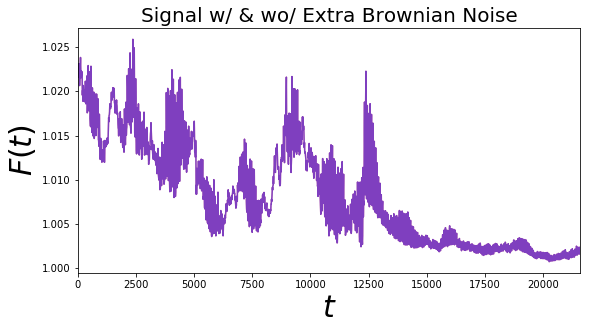

In [27]:
plt.figure(figsize=(9,4.5))
plt.plot(T,Y,'r',alpha=0.5)
plt.plot(T,A_m*D_m,'b',alpha=0.5)
plt.xlim([l_t,h_t]);
plt.xlabel('$t$',size=30);
plt.ylabel('$F(t)$',size=30);
plt.title('Signal w/ & wo/ Extra Brownian Noise',size=20);
plt.show()

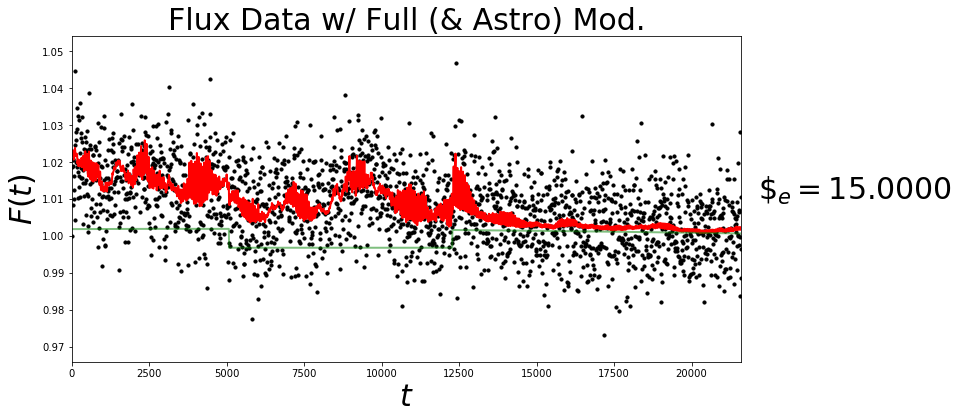

In [28]:
plt.figure(figsize=(12,6))
plt.scatter(T,Y_d,c='k',s=10)
##
# for i in np.linspace(0,N-1,N):
#     plt.plot([T[i],T[i]],[Y_d[i]-SigF_true,Y_d[i]+SigF_true],c=(0,1,1),zorder=0)
##
plt.plot(T,Y,'r',lw=2)
plt.plot(T,A_m,'g',lw=2,alpha=0.5)
plt.xlim([l_t,h_t]);
plt.xlabel('$t$',size=30);
Yd_up,Yd_dw = np.amax(Y_d),np.amin(Y_d)
Yd_scl = Yd_up - Yd_dw
plt.ylim([Yd_dw - 0.1*Yd_scl,Yd_up + 0.1*Yd_scl])
plt.ylabel('$F(t)$',size=30);
plt.title('Flux Data w/ Full (& Astro) Mod.',size=30);
plt.figtext(0.92,0.5,r'$\$_{e} = %.4f$' % significance_decl,size=30)
plt.show()

# SigF_true/Ecl_true[2]

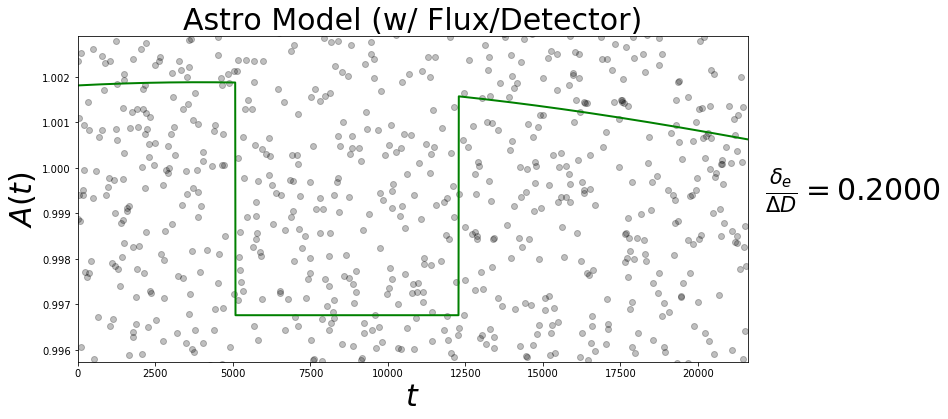

In [29]:
plt.figure(figsize=(12,6))
plt.scatter(T,Y_d/D_m,c='k',alpha=0.25)
plt.plot(T,A_m,'g',lw=2)
plt.xlim([l_t,h_t]);
plt.xlabel('$t$',size=30);
Am_up,Am_dw = np.amax(A_m),np.amin(A_m)
Am_scl = Am_up - Am_dw
plt.ylim([Am_dw - 0.2*Am_scl,Am_up + 0.2*Am_scl])
plt.ylabel('$A(t)$',size=30);
plt.title('Astro Model (w/ Flux/Detector)',size=30);
plt.figtext(0.92,0.5,r'$\frac{\delta_{e}}{\Delta D} = %.4f$' % ratio_decl_DelD,size=30)  # Inverse for paper(?)
plt.show()

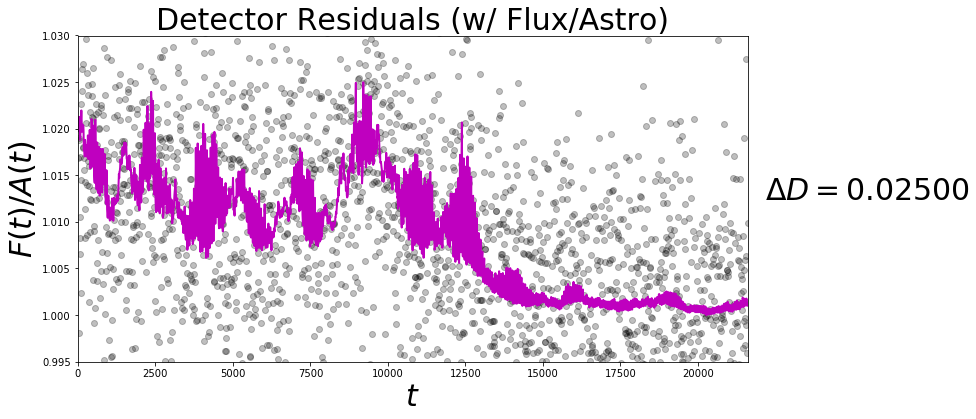

D(x0,y0) Mean = 1.00809


In [30]:
plt.figure(figsize=(12,6))
plt.scatter(T,Y_d/A_m,c='k',alpha=0.25)
plt.plot(T,D_m,'m',lw=2)
plt.xlim([l_t,h_t]);
plt.xlabel('$t$',size=30);
Dm_up,Dm_dw = np.amax(D_m),np.amin(D_m)
Dm_scl = Dm_up - Dm_dw
plt.ylim([Dm_dw - 0.2*Dm_scl,Dm_up + 0.2*Dm_scl])
plt.ylabel('$F(t)/A(t)$',size=30);
plt.title('Detector Residuals (w/ Flux/Astro)',size=30);
plt.figtext(0.92,0.5,r'$\Delta D = %.5f$' % ideal_Delta_D,size=30)
plt.show()

print('D(x0,y0) Mean = %.5f' % np.mean(D_m))

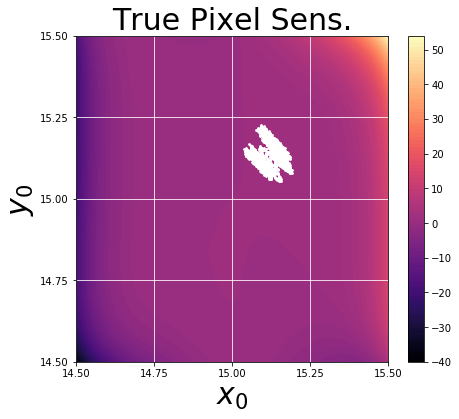

In [31]:
X_bull,Y_bull = np.meshgrid(np.linspace(14.5,15.5,101),np.linspace(14.5,15.5,101))
if want_noisyM_key == True:
    FX_bull,FY_bull = np.ravel(X_bull),np.ravel(Y_bull)
    FM_bull = xtra_Dm_noise(FX_bull,FY_bull,C_UTin,101*101,preK_X,preK_Y,Master_pixNoi)
    M_bull = np.reshape(FM_bull,(101,101))
else:
    M_bull = perf_detect_model(X_bull,Y_bull,C_UTin,101*101)

plt.figure(figsize=(7,6))
my_Smap = plt.contourf(X_bull,Y_bull,M_bull,100,cmap=cm.magma)
plt.colorbar(my_Smap)
plt.xticks([14.5,14.75,15.0,15.25,15.5])
plt.yticks([14.5,14.75,15.0,15.25,15.5])
plt.grid(True,which='major',color='white')
plt.scatter(xNt_perf,yNt_perf,color=(1,1,1),s=3)
plt.xlabel('$x_{0}$',size=30);
plt.ylabel('$y_{0}$',size=30);
plt.title('True Pixel Sens.',size=30);
plt.xlim([14.5,15.5])
plt.ylim([14.5,15.5])
plt.show()

In [32]:
# # # # #

# X_bull,Y_bull = np.meshgrid(np.linspace(14.5,15.5,101),np.linspace(14.5,15.5,101))
# # if want_noisyM_key == True:
# #     FX_bull,FY_bull = np.ravel(X_bull),np.ravel(Y_bull)
# #     FM_bull = xtra_Dm_noise(FX_bull,FY_bull,C_UTin,101*101,preK_X,preK_Y,Master_pixNoi)
# #     M_bull = np.reshape(FM_bull,(101,101))
# # else:
# #     M_bull = perf_detect_model(X_bull,Y_bull,C_UTin,101*101)
# M_bull = -0.1*(X_bull - 15.0)**2.0 + -0.1*(Y_bull - 15.0)**2.0 + 1.01

# plt.figure(figsize=(5,4))
# # my_Smap = plt.contourf(X_bull,Y_bull,M_bull,100,cmap=cm.viridis)
# my_Smap = plt.imshow(M_bull,interpolation='hermite',origin='lower',
#            extent=[14.5,15.5,14.5,15.5],cmap=cm.viridis)
# plt.colorbar(my_Smap,ticks=[])
# plt.xticks([14.5,14.75,15.0,15.25,15.5],['','','','',''])
# plt.yticks([14.5,14.75,15.0,15.25,15.5],['','','','',''])
# # plt.grid(True,which='major',color='white')
# # plt.scatter(xNt_perf,yNt_perf,color=(1,1,1),s=3)
# # plt.xlabel('Pixel x',size='x-large');
# # plt.ylabel('Pixel y',size='x-large');
# # plt.title('True Pixel Sens.',size=30);
# plt.xlim([14.5,15.5])
# plt.ylim([14.5,15.5])
# plt.tight_layout()
# # plt.savefig('pixel_examp.pdf')
# plt.show()

# # # # #

In [33]:
# # Poly-from-roots example area
# xxbobex = np.linspace(-0.4,0.4,100001)
# plt.plot(xxbobex,np.polynomial.polynomial.polyval(xxbobex,[0.0,-0.36,0.0,49,0.0,-1400,0,10000]))
# plt.ylim(-0.1,0.1)
# plt.show()

In [34]:
Gauss_key = False  # False uniform, True Gaussian
# Cn_out = int((polyO_out+2)*(polyO_out+1)/2) - 1  # Fit C's needed; minus 1 because offset is now fixed
out_Da,out_Db,Cn_out = det_cof_limiter(polyO_out,UTout_i[0],UTout_i[1])  # Out poly limits and Fit C's number
out_nonoff_mask = (np.indices(out_Db.shape) != polyO_out)[0]
linear_Cmax_ratio = out_Db[polyO_out-1]/Db[polyO_in-1]  # Out/In of max linear poly term

cn_out_Vector = np.zeros(Cn_out+1)  # Output poly Cn holder
cn_out_Vector[polyO_out] = 1.0  # Fix the offset term to 1.0

### Astro, Eclipse, and Detector Coeff. priors
if Gauss_key == False:
    pri_AstEcl = np.array([[3.0*Ab_i[0],1.0,2.0*pi,h_t,(h_t - l_t),10.0*Ecl_Tii[0]],
                           [0.1*Aa_i[0],0.001,0,l_t,0.0,0.0]])
    
    if linear_Cmax_ratio >= 2:  # i.e. Double the range that was possible after scaling the in_poly
        pri_DCoeff = np.vstack((out_Db[out_nonoff_mask],out_Da[out_nonoff_mask]))
    else:
        pri_DCoeff = np.vstack((out_Db[out_nonoff_mask],out_Da[out_nonoff_mask]))*(1.0/linear_Cmax_ratio)
        
#     pri_DCoeff = np.array([[0.1],[-0.1]])*np.ones(Cn_out)  # [0.2,-0.2]; decrease?
else:
    pri_AstEcl = np.array([[0.5*(Ab_i[0]+Aa_i[0]),0.25,1.0,
                            (h_t - l_t)/2.0,(h_t - l_t)/10.0,dummy_Delta_D],
                           [5.0*(Ab_i[0]-Aa_i[0]),5.0,2.5,
                            2.5*(h_t - l_t),(h_t - l_t),5.0*dummy_Delta_D]])
    
    if linear_Cmax_ratio >= 1:  # i.e. The range that was possible after scaling the in_poly
        pri_DCoeff = np.vstack((np.zeros(Cn_out),5.0*out_Db[out_nonoff_mask]))
    else:
        pri_DCoeff = np.vstack((np.zeros(Cn_out),5.0*out_Db[out_nonoff_mask]))*(1.0/linear_Cmax_ratio)

#     pri_DCoeff = np.array([[0.0],[1.0]])*np.ones(Cn_out)

In [35]:
def mvG_noise(sx,sy,rho,n_data):  # Multivariate Gaussian Noise
    mu = np.array([0.0,0.0])
    cov = np.array([[sx**2.0,rho*sx*sy],[rho*sx*sy,sy**2.0]])
    D = np.random.multivariate_normal(mu,cov,n_data)
    dx,dy = D[:,0],D[:,1]
    return dx,dy

In [36]:
noisy_key = False

if rerun_flag == True:
        storage_xNt,storage_yNt = xNt_vals,yNt_vals
        storage_sigcent = np.array([sigx_cent,sigy_cent,rho_cent])  # [sx,sy,rho]

sigx_cent = 0.01*(np.amax(xNt_perf) - np.amin(xNt_perf))
sigy_cent = 0.01*(np.amax(yNt_perf) - np.amin(yNt_perf))
rho_cent = np.random.random() - 0.5  # Takes values from -1.0 to 1.0, though probably don't use the extremes
Cov_true = np.array([sigx_cent,sigy_cent,rho_cent])
# Cov_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[-4:-1]
if noisy_key == True:
    # Adding "noise" to true xo and yo, now with covariance!
    dxcent,dycent = mvG_noise(sigx_cent,sigy_cent,rho_cent,N)  
    xNt_vals = xNt_perf + dxcent
    yNt_vals = yNt_perf + dycent
else:
    xNt_vals = xNt_perf  # IF you wanna test the real values at some point...
    yNt_vals = yNt_perf
    
rerun_flag = True  # Turning on the flag, in case you try second noisy centroids

In [37]:
# ig1,ig2,ig3,ig4,ig5,xNt_vals,yNt_vals,ig6,ig7 = np.vsplit(np.load(file_Name+'EMCEE_PBJ_data.npy'),9)
# xNt_vals,yNt_vals = xNt_vals[0],yNt_vals[0]

# del ig1,ig2,ig3,ig4,ig5,ig6,ig7

In [38]:
### Uncertainty and Covariance priors
if Gauss_key == False:
    pri_SigF = np.array([[10.0*SigF_true[0]],[0.0]])
    pri_Cov = np.array([[100.0*sigx_cent,100.0*sigy_cent,1.0],[0.0,0.0,-1.0]])
else:
    pri_SigF = np.array([[(within_ecl_N**0.5)*Ecl_true[2]],[5.0*(within_ecl_N**0.5)*Ecl_true[2]]])  # Assume $_e = 1
    pri_Cov = np.array([[10.0*sigx_cent,10.0*sigy_cent,0.0],[100.0*sigx_cent,100.0*sigy_cent,5.0]])
#     pri_SigF = np.vstack((SigF_true,[0.01]))
#     pri_Cov = np.vstack((Cov_true,[20.0*sigx_cent,20.0*sigy_cent,1.0]))

In [39]:
### BLISS-related definitions
def lh_axes_binning(x_o,y_o,b_n,n_data):
    plt.figure(figsize=(6,6))
    xy_C,x_edg,y_edg,viz = plt.hist2d(x_o,y_o,b_n,cmap=cm.viridis);
    plt.title('Bin Counts',size=30)
    plt.xlabel('$x_{0}$',size=30);
    plt.ylabel('$y_{0}$',size=30);
    plt.colorbar(viz)
    x_k = x_edg[1:] - 0.5*(x_edg[1:] - x_edg[0:-1])
    y_k = y_edg[1:] - 0.5*(y_edg[1:] - y_edg[0:-1])
    x_Knt,y_Knt = np.meshgrid(x_k,y_k)
    
    l_b_x,h_b_x = lh_knot_ass(x_k,x_o,b_n,n_data)
    l_b_y,h_b_y = lh_knot_ass(y_k,y_o,b_n,n_data)
    
    return l_b_x,h_b_x,l_b_y,h_b_y,x_k,y_k,xy_C,x_edg,y_edg,x_Knt,y_Knt  # Edges and Knot mesh included


def lh_knot_ass(xy_k,xy_o,b_n,n_data):
    bad_l_xy = (xy_o < xy_k[0])  # pre-finding points "outside" the knots
    bad_h_xy = (xy_o > xy_k[-1]) 
    
    mid_xy_cln = np.transpose(np.tile(xy_k,(n_data,1)))
    diff_xy_cln = xy_o - mid_xy_cln
    diff_xy_cln[diff_xy_cln < 0] = (xy_k[-1] - xy_k[0])
    l_b_xy = np.argmin(diff_xy_cln**2.0,axis=0)
    
    diff_xy_cln = mid_xy_cln - xy_o
    diff_xy_cln[diff_xy_cln < 0] = (xy_k[-1] - xy_k[0])
    h_b_xy = np.argmin(diff_xy_cln**2.0,axis=0)
    
    l_b_xy[l_b_xy == b_n-1] = b_n-2  # tuning l_b_xy upper bound and vice versa
    h_b_xy[h_b_xy == 0] = 1
    h_b_xy[h_b_xy == l_b_xy] += 1  # Avoiding same bin reference (PROBLEMS?)
    
    l_b_xy[bad_l_xy] = 0  # manually extrapolating points "outside" the knots
    h_b_xy[bad_l_xy] = 1
    l_b_xy[bad_h_xy] = b_n-2
    h_b_xy[bad_h_xy] = b_n-1
    
    return l_b_xy,h_b_xy


def which_NNI(xy_Ct,l_b_x,h_b_x,l_b_y,h_b_y):
    bad_left = np.logical_or(xy_Ct[l_b_y,l_b_x] == 0.1,xy_Ct[l_b_y,h_b_x] == 0.1)
    bad_right = np.logical_or(xy_Ct[h_b_y,l_b_x] == 0.1,xy_Ct[h_b_y,h_b_x] == 0.1)
    nni_mask = np.logical_or(bad_left,bad_right)
    if all_NNI_key == True:
        nni_mask = np.ones(nni_mask.shape).astype(bool)
    return nni_mask,np.logical_not(nni_mask)


def lh_bin_to_knot(x_k,y_k,l_b_x,h_b_x,l_b_y,h_b_y):
    l_x_K = x_k[l_b_x]  # Index arrays are awesome!
    h_x_K = x_k[h_b_x]
    l_y_K = y_k[l_b_y]
    h_y_K = y_k[h_b_y]
    return l_x_K,h_x_K,l_y_K,h_y_K


def bound_knot(x_o,y_o,l_b_x,h_b_x,l_b_y,h_b_y,l_x_K,h_x_K,l_y_K,h_y_K,n_data):
    left = (x_o - l_x_K <= h_x_K - x_o)
    right = np.logical_not(left)
    bottom = (y_o - l_y_K <= h_y_K - y_o)
    top = np.logical_not(bottom)
    
    xo_B_i,yo_B_i = np.zeros(n_data),np.zeros(n_data)
    xo_B_i[left] = l_b_x[left]
    xo_B_i[right] = h_b_x[right]
    yo_B_i[bottom] = l_b_y[bottom]
    yo_B_i[top] = h_b_y[top]
    
    return xo_B_i.astype(int),yo_B_i.astype(int)


def bliss_dist(x_o,y_o,l_x_K,h_x_K,l_y_K,h_y_K):
    LLd = (h_x_K - x_o)*(h_y_K - y_o)
    LRd = (x_o - l_x_K)*(h_y_K - y_o)
    ULd = (h_x_K - x_o)*(y_o - l_y_K)
    URd = (x_o - l_x_K)*(y_o - l_y_K)
    return LLd,LRd,ULd,URd

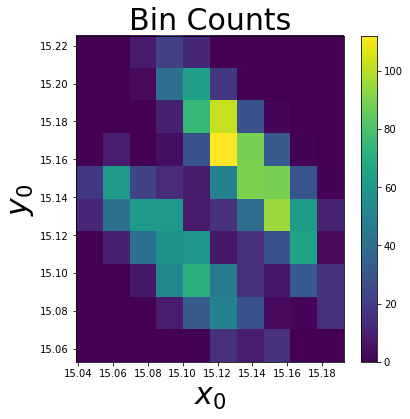

In [40]:
##### Pre-computing D(xo,yo) associations
N_bin = 10
N_bin = THE_input_N_bin  # Again, just in case, setting from the value at the top

low_bx,high_bx,low_by,high_by,x_Knots,y_Knots,BK_T,xEdg,yEdg,xKmesh,yKmesh = lh_axes_binning(xNt_vals,yNt_vals,N_bin,N)
BK_T[BK_T == 0] = 0.1  # Avoid division errors; BK_T = BoundKnot_Tally

tBK_T = np.transpose(BK_T)  # Since BK_T has [x,y] ordering and we want [y,x] for visualizing + consistency

NNI,BLS = which_NNI(tBK_T,low_bx,high_bx,low_by,high_by)  # Data mask for both methods
delta_xo,delta_yo = x_Knots[1] - x_Knots[0],y_Knots[1] - y_Knots[0]

low_Kx,high_Kx,low_Ky,high_Ky = lh_bin_to_knot(x_Knots,y_Knots,low_bx,high_bx,low_by,high_by)
xNt_B_i,yNt_B_i = bound_knot(xNt_vals,yNt_vals,low_bx,high_bx,low_by,high_by,low_Kx,high_Kx,low_Ky,high_Ky,N)
LL_dst,LR_dst,UL_dst,UR_dst = bliss_dist(xNt_vals,yNt_vals,low_Kx,high_Kx,low_Ky,high_Ky)

Dxy_Full = np.zeros((N,N_bin,N_bin))
Dxy_Solo = np.zeros((N_bin,N_bin))
Dxy_i = np.linspace(0,N-1,N).astype(int)

flux_bliss = np.zeros(N)

xNt_B_lin = xNt_B_i + (N_bin*yNt_B_i)  # Linear indexing for faster 'np.bincount' routine!

In [41]:
### For full MCMC: jumping in ALL knot parameters
mask_goodBKT = (BK_T != 0.1)
tmask_goodBKT = (tBK_T != 0.1)  # The important version for [y,x] consistency
tot_goodK = len(tBK_T[tmask_goodBKT])

# "True" detector values for theta, using knots computed with centroid noise.
Kfl_true = perf_detect_model(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],C_UTin,tot_goodK)  # DCs_true
# Kfl_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[6+(Cn_in+1)+Cn_out:-4]

print('N/K = %.2f' % (N/tot_goodK))

N/K = 32.00


In [42]:
### Knot Values prior
if Gauss_key == False:
    pri_Knots = np.array([[np.amax(Y_d)],[np.amin(Y_d)]])*np.ones((2,tot_goodK))  # [[2.0*np.amax(Kfl_true)],[0.0]]
else:
    pri_Knots = np.array([[np.mean(Kfl_true)],[15.0*np.std(Kfl_true)]])*np.ones((2,tot_goodK))
#     pri_Knots = np.vstack((Kfl_true,3.0*np.std(Kfl_true)*np.ones(tot_goodK)))

In [43]:
ext_bounds = [x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]]

def style_maps():
    plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
    plt.xticks(xEdg,rotation=45,visible=False)
    plt.setp(plt.gca().get_xticklabels()[::5],visible=True)
    plt.yticks(yEdg,visible=False)
    plt.setp(plt.gca().get_yticklabels()[::5],visible=True)
    plt.grid(True,which='major')
    plt.xlabel('$x_{0}$',size=30);
    plt.ylabel('$y_{0}$',size=30);
    return

In [44]:
# plt.figure(figsize=(12,6))
# plt.subplot(121)
# plt.scatter(xNt_vals[BLS],yNt_vals[BLS],color=(0,0,1))
# plt.scatter(xNt_vals[NNI],yNt_vals[NNI],color=(0,0,0.4))
# style_maps()
# plt.scatter(xKmesh,yKmesh,color='0.7',marker='x')
# plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],color='k',marker='x',s=50)
# plt.title('Centroid Groups',size=30);
# # plt.legend(('BLISS','NNI'),bbox_to_anchor=(1.3,0.8))

# plt.subplot(122)
# plt.scatter(xNt_vals[BLS],yNt_vals[BLS],color=(0,0,1))
# plt.scatter(xNt_vals[NNI],yNt_vals[NNI],color=(0,0,0.4))
# plt.xticks([14.5,14.75,15.0,15.25,15.5])
# plt.yticks([14.5,14.75,15.0,15.25,15.5])
# plt.grid(True,which='major')
# plt.scatter(xKmesh,yKmesh,color='0.7',marker='x',alpha=0.25)
# plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],color='k',marker='x',s=50,alpha=0.25)
# plt.xlabel('$x_{0}$',size=30);
# plt.ylabel('$y_{0}$',size=30);
# plt.title('Pixel Scale',size=30);
# plt.legend(('BLISS','NNI'),bbox_to_anchor=(1.3,0.8))
# plt.xlim([14.5,15.5])
# plt.ylim([14.5,15.5])

# plt.tight_layout()
# plt.show()

In [45]:
# plt.figure(figsize=(6,6))
# plt.scatter(xNt_perf,yNt_perf,color=(1,0.5,0),marker='o',alpha=0.75)
# plt.scatter(xNt_vals,yNt_vals,color=(0,0,0.75),marker='o',alpha=0.75)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color='0.7',marker='x')
# plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],color='k',marker='x',s=50)
# plt.title('Centroid Deviations',size=30);
# plt.legend(('Perfect Centroids','Measured Centroids'),bbox_to_anchor=(1.5,0.8))
# plt.show()

In [46]:
# Faster 'B'-type flux summation using 'np.bincount' (learned while dealing with slow covariance functions) 
def map_flux_avgQuick(data,ast,dxyi_lin):
    dxy_map = ((np.bincount(dxyi_lin,weights=data/ast,
                            minlength=(N_bin*N_bin)).reshape((N_bin,N_bin)))/tBK_T)  # Avg flux at each data knot
    return dxy_map  # Using [y,x] for consistency

# Note use of 'minlength': you'd often get output that's too short otherwise! (i.e. not EVERY possible knot)

In [47]:
# Legacy 'B'-type flux summation
def map_flux_avg(data,ast,dxy_cln,dxy_ind):
#     dxy_cln[dxy_ind,yNt_B_i,xNt_B_i] = 0  # Probably unnecessary?
    dxy_cln[dxy_ind,yNt_B_i,xNt_B_i] = data/ast   # Using [y,x] for consistency
    dxy_map = np.sum(dxy_cln,axis=0)/tBK_T  # Avg flux at each data knot
    return dxy_map

In [48]:
def map_flux_jumped(dxy_sing,theta_K):
#     dxy_sing[tmask_goodBKT] = 0  # Probably unnecessary?
    dxy_sing[tmask_goodBKT] = theta_K  # Using "tmask_goodBKT" for consistency
    return dxy_sing

In [49]:
# ### Comparing Sensitivity Maps
# fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
# F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# minviz = np.amin(F_avg[tmask_goodBKT])
# maxviz = np.amax(F_avg[tmask_goodBKT])

# plt.figure(figsize=(12,12))
# plt.subplot(221)
# m_B_map = plt.imshow(fB_avg,interpolation='hermite',origin='lower',
#                      extent=[x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]],
#                      cmap=cm.magma,vmin=minviz,vmax=maxviz)
# plt.colorbar(m_B_map)
# coverup = plt.imshow(tmask_goodBKT,origin='lower',extent=ext_bounds,
#                   cmap=cm.gray,vmin=0.25,vmax=0.75)
# coverup.cmap.set_under(color='0.95',alpha=1)
# coverup.cmap.set_over(alpha=0)
# style_maps()
# plt.scatter(xKmesh[fB_avg > maxviz],yKmesh[fB_avg > maxviz],color=(1,0,0),marker='.')
# plt.scatter(xKmesh[np.logical_and(fB_avg < minviz,fB_avg > 0)],
#             yKmesh[np.logical_and(fB_avg < minviz,fB_avg > 0)],color=(0,1,1),marker='.')
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('BLISS Map $\sigma_{F}$',size=30)

# plt.subplot(222)
# PJ_range = maxviz - minviz
# m_PJ_map = plt.imshow(F_avg,interpolation='hermite',origin='lower',
#                      extent=[x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]],
#                      cmap=cm.magma,vmin=minviz,vmax=maxviz)
# plt.colorbar(m_PJ_map)
# coverup = plt.imshow(tmask_goodBKT,origin='lower',extent=ext_bounds,
#                   cmap=cm.gray,vmin=0.25,vmax=0.75)
# coverup.cmap.set_under(color='0.95',alpha=1)
# coverup.cmap.set_over(alpha=0)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('Real (P @ Knots)',size=30)

# plt.subplot(223)
# # B_PJdiff = (fB_avg - F_avg)/PJ_range
# # B_PJdiff = (fB_avg - F_avg)/SigF_true
# B_PJdiff = (fB_avg - F_avg)*(tBK_T**0.5)/SigF_true
# # B_PJdiff = ((N/tot_goodK)**0.5)*(fB_avg - F_avg)/SigF_true
# # B_PJdiff = (fB_avg - F_avg)*(within_ecl_N**0.5)/SigF_true  # 5/13/16: Nick sugg. (off Kevin) compare discrep to sig_photon in-eclipse.
# limviz = np.amax(np.absolute(B_PJdiff[tmask_goodBKT]))
# B_PJdiff[tmask_goodBKT == False] = np.nan  # So bad knots fall outside the color range.
# B_PJmap = plt.imshow(B_PJdiff,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.BrBG_r,vmin=(-limviz),vmax=limviz)
# plt.colorbar(B_PJmap)
# B_PJmap.cmap.set_bad(color='k',alpha=1.0)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('(B - Real)/$\sigma$',size=30)

# plt.subplot(224)
# B_PJmap2 = plt.imshow(B_PJdiff,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.coolwarm,vmin=-3,vmax=3)
# plt.colorbar(B_PJmap2)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('$\leftarrow$ Unity Scale',size=30)

# plt.tight_layout()
# plt.show()

# # New correct normalization by number of knots- duh! (Thanks Kevin)
# print('(B - Re)/sigma_noise values')
# this_wavg = np.sum(B_PJdiff[tmask_goodBKT]*tBK_T[tmask_goodBKT])/N
# print('Mean = %.3f' % this_wavg)
# this_wvarA = np.sum(((B_PJdiff[tmask_goodBKT] - this_wavg)**2.0)*tBK_T[tmask_goodBKT])
# this_wvarB = N/((N**2.0) - np.sum(tBK_T[tmask_goodBKT]**2.0))
# this_wstd = (this_wvarA*this_wvarB)**0.5
# print('STD = %.3f' % this_wstd)

In [50]:
# print('Reg. Mean = %.3f' % (np.mean(B_PJdiff[tmask_goodBKT])))
# print('Reg. STD = %.3f' % (np.std(B_PJdiff[tmask_goodBKT])))

In [51]:
###
# %matplotlib inline
# %matplotlib osx

In [52]:
# fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
# F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# minviz = np.amin(F_avg[tmask_goodBKT])
# maxviz = np.amax(F_avg[tmask_goodBKT])

# # star_colrs = np.zeros((tot_goodK,4))
# # star_colrs[:,:3] = np.array([0,0.75,1])
# star_colrs = tBK_T[tmask_goodBKT]  # [:,3]  /np.amax(tBK_T[tmask_goodBKT])

# secs_in_hr = 3600.0
# plt.figure(figsize=(12,6))

# plt.subplot2grid((2,5),(0,0),rowspan=1,colspan=2)
# # plt.subplot(131)
# plt.plot(T/secs_in_hr,xNt_vals,'0.25',lw=0.5)
# plt.xlim([l_t/secs_in_hr,h_t/secs_in_hr]);
# # plt.xlabel('Time (hrs)',size='x-large');
# plt.gca().set_xticklabels([])
# plt.ylabel('Centroid x',size='x-large');
# plt.ylim([np.amin(xNt_vals)-0.025,0.025+np.amax(xNt_vals)])
# plt.locator_params(axis='y',nbins=5)
# # good_Xs = plt.gca().get_yticks()
# # plt.title('Flux Data w/ Full (& Astro) Mod.',size=30);

# plt.subplot2grid((2,5),(1,0),rowspan=1,colspan=2)
# # plt.subplot(132)
# plt.plot(T/secs_in_hr,yNt_vals,'0.25',lw=0.5)
# plt.xlim([l_t/secs_in_hr,h_t/secs_in_hr]);
# plt.xlabel('Time (hrs)',size='x-large');
# # plt.gca().set_xticklabels([])
# plt.ylabel('Centroid y',size='x-large');
# plt.ylim([np.amin(yNt_vals)-0.025,0.025+np.amax(yNt_vals)])
# plt.locator_params(axis='y',nbins=5)
# # good_Ys = plt.gca().get_yticks()
# # plt.title('Flux Data w/ Full (& Astro) Mod.',size=30);

# plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=3)
# # plt.subplot(133)
# plt.scatter(xNt_vals,yNt_vals,color=(0,0,0),alpha=0.2,s=10,marker='.')
# # plt.scatter(xNt_vals[BLS],yNt_vals[BLS],color=(0,0,0),alpha=0.25,s=10,marker='.')
# # plt.scatter(xNt_vals[NNI],yNt_vals[NNI],color=(0.5,0,0),alpha=0.25,s=10,marker='.')
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# # plt.xticks([])
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# # plt.title('True Sensitivity',size='large')
# plt.xlim([x_Knots[0] - 0.5*delta_xo,x_Knots[-1] + 0.5*delta_xo])
# plt.ylim([y_Knots[0] - 0.5*delta_yo,y_Knots[-1] + 0.5*delta_yo])
# plt.locator_params(axis='x',nbins=8)
# plt.locator_params(axis='y',nbins=8)
# my_stars = plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],c=star_colrs,cmap=cm.Blues,
#             edgecolor='k',marker='*',s=250,vmin=0)  # (0,0.75,1)
# plt.colorbar(my_stars,label='Linked Centroids',shrink=1.0)
# plt.scatter(xKmesh[tmask_goodBKT == False],yKmesh[tmask_goodBKT == False],color=(1,0.75,0.75),
#             marker='x',s=50)  #,alpha=0.25)  # (0,0.375,0.5)
# plt.legend(('Centroids','Good Knots','Bad Knots'),loc='lower left',bbox_to_anchor=(0.025,0.025),
#            fontsize='small',fancybox=True)  # loc='lower right',bbox_to_anchor=(0.975,0.025)

# plt.tight_layout(w_pad=3)
# plt.show()

In [53]:
from matplotlib.ticker import ScalarFormatter

mynewmap_ind = np.ravel(np.transpose(np.tile(np.linspace(0,N_bin-1,N_bin).astype(int),(N_bin,1))))
newmap_xxi,newmap_yyi = np.meshgrid(mynewmap_ind,mynewmap_ind)
newmap_badmask = (tmask_goodBKT[newmap_yyi,newmap_xxi] == False)

Smap_bounds = [np.amin(xNt_perf),np.amax(xNt_perf),np.amin(yNt_perf),np.amax(yNt_perf)]

/Users/jhoffart/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/jhoffart/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


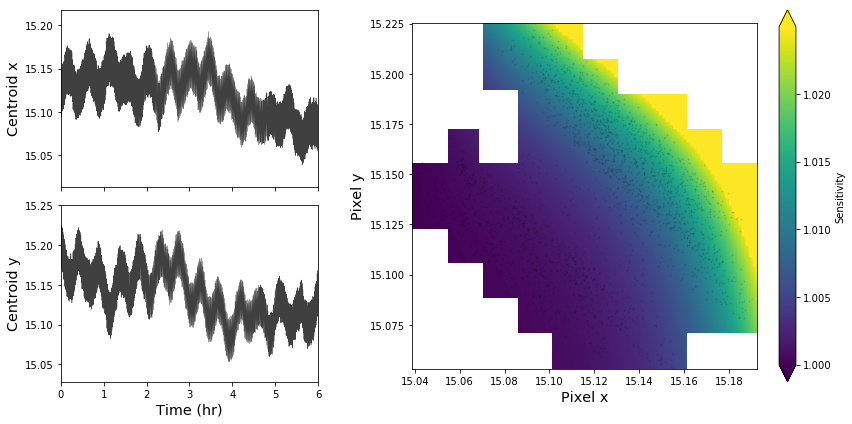

In [54]:
fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# minviz = np.amin(F_avg[tmask_goodBKT])
# maxviz = np.amax(F_avg[tmask_goodBKT])
minviz = np.amin(D_m)
maxviz = np.amax(D_m)

# star_colrs = np.zeros((tot_goodK,4))
# star_colrs[:,:3] = np.array([0,0.75,1])
star_colrs = tBK_T[tmask_goodBKT]  # [:,3]  /np.amax(tBK_T[tmask_goodBKT])

easy_tic = np.linspace(0.990,1.010,21)

secs_in_hr = 3600.0
plt.figure(figsize=(12,6))

plt.subplot2grid((2,5),(0,0),rowspan=1,colspan=2)
# plt.subplot(131)
plt.plot(T/secs_in_hr,xNt_perf,'0.25',lw=0.5)
plt.xlim([l_t/secs_in_hr,h_t/secs_in_hr]);
# plt.xlabel('Time (hrs)',size='x-large');
plt.gca().set_xticklabels([])
plt.ylabel('Centroid x',size='x-large');
plt.ylim([np.amin(xNt_perf)-0.025,0.025+np.amax(xNt_perf)])
plt.locator_params(axis='y',nbins=5)
# good_Xs = plt.gca().get_yticks()
# plt.title('Flux Data w/ Full (& Astro) Mod.',size=30);

plt.subplot2grid((2,5),(1,0),rowspan=1,colspan=2)
# plt.subplot(132)
plt.plot(T/secs_in_hr,yNt_perf,'0.25',lw=0.5)
plt.xlim([l_t/secs_in_hr,h_t/secs_in_hr]);
plt.xlabel('Time (hr)',size='x-large');
# plt.gca().set_xticklabels([])
plt.ylabel('Centroid y',size='x-large');
plt.ylim([np.amin(yNt_perf)-0.025,0.025+np.amax(yNt_perf)])
plt.locator_params(axis='y',nbins=5)
# good_Ys = plt.gca().get_yticks()
# plt.title('Flux Data w/ Full (& Astro) Mod.',size=30);

plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=3)
# plt.subplot(133)
plt.scatter(xNt_perf,yNt_perf,color=(0,0,0),alpha=0.1,s=3,marker='.')

X_bull,Y_bull = np.meshgrid(np.linspace(np.amin(xNt_perf),np.amax(xNt_perf),int(N_bin**2)),
                            np.linspace(np.amin(yNt_perf),np.amax(yNt_perf),int(N_bin**2)))
M_bull = perf_detect_model(X_bull,Y_bull,C_UTin,int(N_bin**4))
M_bull[newmap_badmask] = np.nan

my_Smap = plt.imshow(M_bull,interpolation='hermite',origin='lower',
           extent=Smap_bounds,cmap=cm.viridis,vmin=minviz,vmax=maxviz)
# my_Smap.cmap.set_bad(color='k',alpha=0.02)
# my_Smap.cmap.set_over(color='r',alpha=1.0)
# my_Smap.cmap.set_under(color='c',alpha=1.0)
Smap_bar = plt.colorbar(my_Smap,label='Sensitivity',extend='both',shrink=1.0)  #ticks=easy_tic
Smap_bar.formatter.set_useOffset(False)
Smap_bar.update_ticks()

plt.gca().set_aspect((np.amax(xNt_perf)-np.amin(xNt_perf))/(np.amax(yNt_perf)-np.amin(yNt_perf)))
# plt.xticks([])
plt.xlabel('Pixel x',size='x-large');
plt.ylabel('Pixel y',size='x-large');
# plt.title('Pixel Sensitivity',size='large')
plt.xlim([np.amin(xNt_perf),np.amax(xNt_perf)])
plt.ylim([np.amin(yNt_perf),np.amax(yNt_perf)])
plt.locator_params(axis='x',nbins=8)
plt.locator_params(axis='y',nbins=8)

plt.tight_layout(w_pad=3)
plt.show()

In [55]:
# fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
# F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# minviz = np.amin(F_avg[tmask_goodBKT])
# maxviz = np.amax(F_avg[tmask_goodBKT])

# # plt.figure(figsize=(12,6))
# plt.figure(figsize=(6,6))

# # plt.subplot2grid((2,6),(0,2),rowspan=2,colspan=2)
# # plt.subplot(121)
# easy_tic = np.linspace(0.990,1.010,21)
# extra_F_avg = F_avg
# extra_F_avg[tmask_goodBKT == False] = np.nan
# PJ_range = maxviz - minviz
# m_PJ_map = plt.imshow(extra_F_avg,interpolation='hermite',origin='lower',
#                       extent=[x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]],
#                       cmap=cm.magma,vmin=minviz,vmax=maxviz)
# my_tr_bar = plt.colorbar(m_PJ_map,ticks=easy_tic,label='Sensitivity',shrink=0.75)
# my_tr_bar.formatter.set_useOffset(False)  # Taking away offset
# my_tr_bar.update_ticks()
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# # plt.xticks([])
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# # plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# # plt.title('True Map',size='large')
# plt.title('True Map',size='large')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=6)

# plt.tight_layout()

# plt.figure(figsize=(6,6))

# # plt.subplot2grid((2,6),(0,4),rowspan=2,colspan=2)
# # plt.subplot(122)
# # B_PJdiff = (fB_avg - F_avg)/PJ_range
# # B_PJdiff = (fB_avg - F_avg)/SigF_true
# B_PJdiff = (fB_avg - F_avg)*(tBK_T**0.5)/SigF_true
# # B_PJdiff = ((N/tot_goodK)**0.5)*(fB_avg - F_avg)/SigF_true
# # B_PJdiff = (fB_avg - F_avg)*(within_ecl_N**0.5)/SigF_true  # 5/13/16: Nick sugg. (off Kevin) compare discrep to sig_photon in-eclipse.
# B_PJdiff[tmask_goodBKT == False] = np.nan  # So bad knots fall outside the color range.

# B_PJmap2 = plt.imshow(B_PJdiff,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.coolwarm,vmin=-3.0,vmax=3.0)
# # B_PJmap2.cmap.set_bad(color='w',alpha=1.0)
# plt.colorbar(B_PJmap2,extend='both',ticks=np.linspace(-3.0,3.0,7),label=r'(BLISS - True) / Photon Noise',shrink=0.75)
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# # plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('BLISS vs True Map',size='large')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=6)

# plt.tight_layout()

# # plt.tight_layout(w_pad=3)
# plt.show()

# ###

In [56]:
# np.amax(B_PJdiff[tmask_goodBKT]),np.amin(B_PJdiff[tmask_goodBKT])

In [57]:
# fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
# F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# minviz = np.amin(F_avg[tmask_goodBKT])
# maxviz = np.amax(F_avg[tmask_goodBKT])

# # star_colrs = np.zeros((tot_goodK,4))
# # star_colrs[:,:3] = np.array([0,0.75,1])
# star_colrs = tBK_T[tmask_goodBKT]  # [:,3]  /np.amax(tBK_T[tmask_goodBKT])

# secs_in_hr = 3600.0
# plt.figure(figsize=(12,6))

# # plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=3)
# plt.subplot(121)
# plt.scatter(xNt_vals,yNt_vals,color=(0,0,0),alpha=0.2,s=2,marker='.')  # s=10
# # plt.scatter(xNt_vals[BLS],yNt_vals[BLS],color=(0,0,0),alpha=0.25,s=10,marker='.')
# # plt.scatter(xNt_vals[NNI],yNt_vals[NNI],color=(0.5,0,0),alpha=0.25,s=10,marker='.')
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# # plt.xticks([])
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# plt.title('Knot Mesh',size='large')
# plt.xlim([x_Knots[0] - 0.5*delta_xo,x_Knots[-1] + 0.5*delta_xo])
# plt.ylim([y_Knots[0] - 0.5*delta_yo,y_Knots[-1] + 0.5*delta_yo])
# plt.locator_params(axis='x',nbins=8)
# plt.locator_params(axis='y',nbins=8)
# my_stars = plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],c=star_colrs,cmap=cm.Purples,
#             edgecolor='k',marker='*',s=175,vmin=1)  # (0,0.75,1), s=250
# plt.colorbar(my_stars,label='Linked Centroids',shrink=0.75)
# plt.scatter(xKmesh[tmask_goodBKT == False],yKmesh[tmask_goodBKT == False],color=(1,0.75,0.75),
#             marker='x',s=35)  #,alpha=0.25)  # (0,0.375,0.5), s=50
# legend = plt.legend(('Centroids','Good Knots','Bad Knots'),loc='lower left',bbox_to_anchor=(0.01,0.01),
#            fontsize='small',fancybox=True)  # loc='lower right',bbox_to_anchor=(0.975,0.025)
# legend.legendHandles[1].set_color(cm.Purples(0.67)[:3])
# legend.legendHandles[1].set_edgecolor('black')

# # plt.subplot2grid((2,6),(0,4),rowspan=2,colspan=2)
# plt.subplot(122)
# # B_PJdiff = (fB_avg - F_avg)/PJ_range
# # B_PJdiff = (fB_avg - F_avg)/SigF_true
# B_PJdiff = (fB_avg - F_avg)*(tBK_T**0.5)/SigF_true
# # B_PJdiff = ((N/tot_goodK)**0.5)*(fB_avg - F_avg)/SigF_true
# # B_PJdiff = (fB_avg - F_avg)*(within_ecl_N**0.5)/SigF_true  # 5/13/16: Nick sugg. (off Kevin) compare discrep to sig_photon in-eclipse.
# B_PJdiff[tmask_goodBKT == False] = np.nan  # So bad knots fall outside the color range.

# B_PJmap2 = plt.imshow(B_PJdiff,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.coolwarm,vmin=-3.0,vmax=3.0)
# # B_PJmap2.cmap.set_bad(color='w',alpha=1.0)
# plt.colorbar(B_PJmap2,extend='neither',ticks=np.linspace(-3.0,3.0,7),
#              label=r'(BLISS - True) / Photon Noise per Bin',shrink=0.75)  # neither' just for this plot
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# # plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('BLISS vs True Map',size='large')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=6)

# plt.tight_layout(w_pad=3)
# plt.show()

In [58]:
# ##### Pre-computing Flux Evaluation Items
# f_binax = 1  # Number of probability eval points along each axis in a bin; '1' FOR SAFETY RIGHT NOW!!!
# evl_x = np.linspace(xEdg[0] + delta_xo/(2*f_binax),xEdg[-1] - delta_xo/(2*f_binax),N_bin*f_binax)
# evl_y = np.linspace(yEdg[0] + delta_yo/(2*f_binax),yEdg[-1] - delta_yo/(2*f_binax),N_bin*f_binax)
# xEmesh,yEmesh = np.meshgrid(evl_x,evl_y)
# xEmesh_n = np.transpose(np.tile(xEmesh,(N,1,1)),axes=(1,2,0))
# yEmesh_n = np.transpose(np.tile(yEmesh,(N,1,1)),axes=(1,2,0))
# delta_ex,delta_ey = evl_x[1] - evl_x[0],evl_y[1] - evl_y[0]

# Ki_Evl = np.ravel(np.transpose(np.tile(np.linspace(0,N_bin-1,N_bin),(f_binax,1)))).astype(int)
# xi_EtoK,yi_EtoK = np.meshgrid(Ki_Evl,Ki_Evl)

# xi_Kstn,yi_Kstn = np.meshgrid(np.linspace(0,N_bin-1,N_bin).astype(int),np.linspace(0,N_bin-1,N_bin).astype(int))
# xi_Kstn_e = np.transpose(np.tile(xi_Kstn,(N_bin*f_binax,N_bin*f_binax,1,1)),axes=(2,3,0,1))
# yi_Kstn_e = np.transpose(np.tile(yi_Kstn,(N_bin*f_binax,N_bin*f_binax,1,1)),axes=(2,3,0,1))

# mask_EtoK = np.logical_and(xi_EtoK == xi_Kstn_e,yi_EtoK == yi_Kstn_e)
# mask_EtoK_n = np.transpose(np.tile(mask_EtoK,(N,1,1,1,1)),axes=(1,2,3,4,0))

In [59]:
# plt.figure(figsize=(6,6))
# style_maps()
# plt.scatter(xEmesh,yEmesh,color=(0,1,1),marker='*')
# plt.scatter(xKmesh,yKmesh,color='0.7',marker='x')
# plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],color='k',marker='x',s=50)
# plt.scatter(xNt_vals,yNt_vals,color=(0,0,0.75),marker='o',alpha=0.2)
# plt.title('Evaluation Grid',size=30)
# plt.legend(('Eval. Points','Knots','Good Knots','Data'),bbox_to_anchor=(1.4,0.8))
# plt.xlim([xEdg[0] - 0.5*(xEdg[1] - xEdg[0]),xEdg[-1] + 0.5*(xEdg[1] - xEdg[0])])
# plt.ylim([yEdg[0] - 0.5*(yEdg[1] - yEdg[0]),yEdg[-1] + 0.5*(yEdg[1] - yEdg[0])])  # Had to add this for some reason...
# plt.show()

In [60]:
def biv_normal(x_n,y_n,mx,my,sx,sy,rho):
    con = 1.0/(2.0*pi*sx*sy*((1 - rho**2.0)**0.5))
    xterm,yterm,xy_term = ((x_n - mx)/sx)**2.0,((y_n - my)/sy)**2.0,(2.0*rho*(x_n - mx)*(y_n - my))/(sx*sy)
    pcon = 1.0/(2*(1 - rho**2.0))
    return con*np.exp(-pcon*(xterm + yterm - xy_term))*delta_ex*delta_ey  # Had missed the -xy before

In [61]:
# %timeit biv_normal(xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent)

In [62]:
### Method to include centroid uncertainties on "B"-type runs
def map_flux_eval(data,ast,M_etok,x_n,y_n,mx,my,sx,sy,rho):
    probxy_evl = biv_normal(x_n,y_n,mx,my,sx,sy,rho)  # [N_evl,N_evl,N]
    raw_map = np.sum(np.sum(probxy_evl,axis=2)*M_etok,axis=(2,3))  # Converting above into [N_bin,N_bin]
    flux_map = np.sum(np.sum((data/ast)*probxy_evl,axis=2)*M_etok,axis=(2,3))  # Ditto
    dxy_map = flux_map/raw_map  # Of course: flux-weighted, instead of tBK_T dividing!
    dxy_map[tmask_goodBKT == False] = 0.0  # Zeroing out bad knots (not BLISS'ed yet)
    return dxy_map

# Note how you multiply by a mask (logical operator) for the maps --> Useful trick sometimes to keep dimensionality!!!

In [63]:
# diffuse_flux = map_flux_eval(Y_d,A_m,mask_EtoK,xEmesh_n,yEmesh_n,
#                              xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent)
# minvizE = np.amin(diffuse_flux[tmask_goodBKT])

# plt.figure(figsize=(6,6))
# f_E_map = plt.imshow(diffuse_flux,interpolation='hermite',origin='lower',
#            extent=[x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]],cmap=cm.magma,vmin=minvizE)
# plt.colorbar(f_E_map)
# # f_E_map.cmap.set_bad(color='k',alpha=0.25)
# coverup2 = plt.imshow(tmask_goodBKT,origin='lower',extent=ext_bounds,
#                   cmap=cm.gray,vmin=0.25,vmax=0.75)
# coverup2.cmap.set_under(color='0.95',alpha=1)
# coverup2.cmap.set_over(alpha=0)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('EVAL Map',size=30)
# plt.show()

In [64]:
# # BEdiff = (diffuse_flux - F_avg)/PJ_range
# BEdiff = (diffuse_flux - F_avg)/SigF_true
# limvizE = np.amax(np.absolute(BEdiff))
# BEdiff[tmask_goodBKT == False] = np.nan  # So bad knots fall outside the color range.

# plt.figure(figsize=(6,6))
# BE_map = plt.imshow(BEdiff,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.coolwarm,vmin=(-limvizE),vmax=limvizE)
# plt.colorbar(BE_map)
# BE_map.cmap.set_bad(color='k',alpha=1.0)
# style_maps()
# plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title('(EV - Real)/$\sigma$',size=30)
# plt.show()

In [65]:
### Method to include centroid uncertainties on "P"-type runs
def sigxy_detect_model(dC_A,x_n,y_n,mx,my,sx,sy,rho,n_data):  # dCs = detector Coefficients
    xe,ye = x_n[:,:,0],y_n[:,:,0]  # Making [N_evl,N_evl]
    d_alone = np.polynomial.polynomial.polyval2d(xe-15.0,ye-15.0,dC_A)
    probxy_evl = np.transpose(biv_normal(x_n,y_n,mx,my,sx,sy,rho),axes=(2,0,1)) # Making [N,N_evl,N_evl]
    d_mdl = d_alone*probxy_evl
    d_mdl = np.sum(d_mdl,axis=(1,2))
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  Norm to sum = N, so mean d_mdl is near 1.0
    return d_mdl  # Slow because of all the evaluations!

# EXAMPLE: sigxy_detect_model(C_UTin,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent,N)

In [66]:
# %timeit sigxy_detect_model(C_UTin,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent,N)

In [67]:
# mask_goodEvl = np.any(np.transpose(mask_EtoK,axes=(2,3,0,1))*tmask_goodBKT,axis=(2,3))
# xoE,yoE = xEmesh[mask_goodEvl],yEmesh[mask_goodEvl]
# N_usedE = len(xoE)

# low_bxE,high_bxE = lh_knot_ass(x_Knots,xoE,N_bin,N_usedE)
# low_byE,high_byE = lh_knot_ass(y_Knots,yoE,N_bin,N_usedE)
# NNI_E,BLS_E = which_NNI(tBK_T,low_bxE,high_bxE,low_byE,high_byE)

# low_KxE,high_KxE,low_KyE,high_KyE = lh_bin_to_knot(x_Knots,y_Knots,low_bxE,high_bxE,low_byE,high_byE)
# xoE_B_i,yoE_B_i = xi_EtoK[mask_goodEvl],yi_EtoK[mask_goodEvl]
# LL_dstE,LR_dstE,UL_dstE,UR_dstE = bliss_dist(xoE,yoE,low_KxE,high_KxE,low_KyE,high_KyE)

# f_bliss_Egrid = np.zeros(xEmesh.shape)
# f_bliss_Evect = np.zeros(N_usedE)

In [68]:
def secondary_bliss(evl_grid,b_flux,dxy_map,x_o,y_o):
    LL = dxy_map[low_byE,low_bxE]*LL_dstE  # Using [y,x] for consistency
    LR = dxy_map[high_byE,low_bxE]*LR_dstE
    UL = dxy_map[low_byE,high_bxE]*UL_dstE
    UR = dxy_map[high_byE,high_bxE]*UR_dstE
    b_flux[BLS_E] = (LL[BLS_E] + LR[BLS_E] + UL[BLS_E] + UR[BLS_E])/(delta_xo*delta_yo)  # BLISS points
    b_flux[NNI_E] = dxy_map[yoE_B_i[NNI_E],xoE_B_i[NNI_E]]  # Nearest Neighbor points
    evl_grid[mask_goodEvl] = b_flux  # Converting to [N_evl,N_evl]
    return evl_grid

In [69]:
### Method to include centroid uncertainties on "J"-type runs (and maybe "B"-type, too)
def sigxy_eval_map(dxy_sing,theta_K,evl_grid,b_flux,x_o,y_o,x_n,y_n,mx,my,sx,sy,rho,n_data):
    dxy_map = map_flux_jumped(dxy_sing,theta_K)  # [N_bin,N_bin]
    f_evl_sqr = secondary_bliss(evl_grid,b_flux,dxy_map,x_o,y_o)  # [N_evl,N_evl]
    probxy_evl = np.transpose(biv_normal(x_n,y_n,mx,my,sx,sy,rho),axes=(2,0,1)) # [N,N_evl,N_evl]
    d_mdl = f_evl_sqr*probxy_evl  # Sens. at eval points * Prob. of seeing each data point there
    d_mdl = np.sum(d_mdl,axis=(1,2))  # Collapse to N-length detector model!
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  Norm to sum = N, so mean d_mdl is near 1.0
    return d_mdl

# Example: sigxy_eval_map(Dxy_Solo,Kfl_true,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,
#                xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent,N)

In [70]:
# ## HOLD OBVIOUSLY, BUT I THINK 'LR' AND 'UL' HAVE SWAPPED INDICES IN VERSION I'VE BEEN USING ALL ALONG!

# def bliss_meth(n_data,b_flux,dxy_map,x_o,y_o):
# #     b_flux[:] = 0  # Probably unnecessary?
#     LL = dxy_map[low_by,low_bx]*LL_dst  # Using [y,x] for consistency
#     LR = dxy_map[high_by,low_bx]*LR_dst
#     UL = dxy_map[low_by,high_bx]*UL_dst
#     UR = dxy_map[high_by,high_bx]*UR_dst
#     b_flux[BLS] = (LL[BLS] + LR[BLS] + UL[BLS] + UR[BLS])/(delta_xo*delta_yo)  # BLISS points
#     b_flux[NNI] = dxy_map[yNt_B_i[NNI],xNt_B_i[NNI]]  # Nearest Neighbor points
# #     b_flux = n_data*b_flux/np.sum(b_flux)  # Normalizing as above
#     return b_flux

In [71]:
def bliss_meth(n_data,b_flux,dxy_map,x_o,y_o):  # # HOPEFULLY GOOD VERSION, FINGERS CROSSED!!!!!!!!!!!
#     b_flux[:] = 0  # Probably unnecessary?
    LL = dxy_map[low_by,low_bx]*LL_dst  # Using [y,x] for consistency
    LR = dxy_map[low_by,high_bx]*LR_dst
    UL = dxy_map[high_by,low_bx]*UL_dst
    UR = dxy_map[high_by,high_bx]*UR_dst
    b_flux[BLS] = (LL[BLS] + LR[BLS] + UL[BLS] + UR[BLS])/(delta_xo*delta_yo)  # BLISS points
    b_flux[NNI] = dxy_map[yNt_B_i[NNI],xNt_B_i[NNI]]  # Nearest Neighbor points
#     b_flux = n_data*b_flux/np.sum(b_flux)  # Normalizing as above
    return b_flux

In [72]:
#####
# Better Covariance Methods
#####

In [73]:
# ### Setting up [Ne,Ne,N] index arrays
# Ne_yi,Ne_xi = np.indices((N_bin*f_binax,N_bin*f_binax))
# Ne_xi_N = np.transpose(np.tile(Ne_xi,(N,1,1)),axes=(1,2,0))
# Ne_yi_N = np.transpose(np.tile(Ne_yi,(N,1,1)),axes=(1,2,0))

# x_near_Ei = np.argmin((xNt_vals - np.transpose(np.tile(evl_x,(N,1))))**2.0,axis=0)
# y_near_Ei = np.argmin((yNt_vals - np.transpose(np.tile(evl_y,(N,1))))**2.0,axis=0)
# x_near_E = evl_x[x_near_Ei]
# y_near_E = evl_y[y_near_Ei] # Getting eval points closest to each data point

In [74]:
# ### Creating "nearest selected" evaluation points to include for each centroid
# evl_range = 5
# select_mapEvl = (np.absolute(x_near_Ei - Ne_xi_N) <= evl_range)*(np.absolute(y_near_Ei - Ne_yi_N) <= evl_range)
# select_mapEvl = np.transpose(np.transpose(select_mapEvl,axes=(2,0,1))*mask_goodEvl,axes=(1,2,0))

# xNt_n = np.tile(xNt_vals,(N_bin*f_binax,N_bin*f_binax,1))
# yNt_n = np.tile(yNt_vals,(N_bin*f_binax,N_bin*f_binax,1))

# xNt_E,yNt_E = xNt_n[select_mapEvl],yNt_n[select_mapEvl]  # Condensed 1D centroid location arrays
# xMesh_nE,yMesh_nE = xEmesh_n[select_mapEvl],yEmesh_n[select_mapEvl]  # Condensed 1D eval point arrays

# blank_EvlN = np.zeros(Ne_yi_N.shape)  # For using in tighter biv_N function and similar

In [75]:
# look_p = 190
# plt.imshow(select_mapEvl[:,:,look_p],origin='bottom')
# plt.show()

In [76]:
# scl_fct = 1.0
# S_x,S_y,R_xy = scl_fct*sigx_cent,scl_fct*sigy_cent,rho_cent
# look_p = 90

# plt.contourf(xEmesh,yEmesh,biv_normal(xEmesh,yEmesh,xNt_vals[look_p],yNt_vals[look_p],S_x,S_y,R_xy),
#              50,cmap=cm.inferno)
# plt.scatter(xEmesh[select_mapEvl[:,:,look_p]],yEmesh[select_mapEvl[:,:,look_p]],color='c',alpha=0.25)
# plt.scatter(x_near_E[look_p],y_near_E[look_p],color='g',s=50,alpha=0.75)
# plt.show()

In [77]:
def bivN_tight(blnkD,x_ne,y_ne,mux_e,muy_e,sx,sy,rho):
    con = 1.0/(2.0*pi*sx*sy*((1 - rho**2.0)**0.5))
    xtrm,ytrm,xytrm = ((x_ne - mux_e)/sx)**2.0,((y_ne - muy_e)/sy)**2.0,(2.0*rho*(x_ne - mux_e)*(y_ne - muy_e))/(sx*sy)
    pcon = 1.0/(2.0*(1 - rho**2.0))
    blnkD[select_mapEvl] = con*np.exp(-pcon*(xtrm + ytrm - xytrm))*delta_ex*delta_ey
    return blnkD

# Example: bivN_tight(blank_EvlN,xMesh_nE,yMesh_nE,xNt_E,yNt_E,sigx_cent,sigy_cent,rho_cent)

In [78]:
# ### Creating 1D index array of EXPLICIT data+knots (i.e. each data point has unique knot index)
# eN_I = np.tile(np.linspace(0,N-1,N),(N_bin*f_binax,N_bin*f_binax,1)).astype(int)
# xi_EtoK_N = np.transpose(np.tile(xi_EtoK,(N,1,1)),axes=(1,2,0))
# yi_EtoK_N = np.transpose(np.tile(yi_EtoK,(N,1,1)),axes=(1,2,0))

# oneD_Klist = np.ravel(xi_EtoK_N + N_bin*yi_EtoK_N + (N_bin*N_bin)*eN_I)

In [79]:
# ### 1D index arrays for faster Eval into Knots summation
# S_sx,S_sy,S_rho = 25,25,19  # 50,50,19
# btm_sx,top_sx = 0.2*sigx_cent,10.0*sigx_cent  # sy and sx with *sig here, instead?
# btm_sy,top_sy = 0.2*sigy_cent,10.0*sigy_cent
# btm_rho,top_rho = -0.9,0.9

# rho_A,sy_A,sx_A = np.meshgrid(np.linspace(btm_rho,top_rho,S_rho),np.linspace(btm_sy,top_sy,S_sy),
#                               np.linspace(btm_sx,top_sx,S_sx),indexing='ij')
# rho_AF,sy_AF,sx_AF = np.ravel(rho_A),np.ravel(sy_A),np.ravel(sx_A)

# rho_I,sy_I,sx_I = np.indices((S_rho,S_sy,S_sx))
# rho_IF,sy_IF,sx_IF = np.ravel(rho_I),np.ravel(sy_I),np.ravel(sx_I)

# tempo_DProb = np.zeros((S_rho,S_sy,S_sx,N,N_bin,N_bin)) # [rho,sigy,sigx,N,y,x]

In [80]:
# HOLY CRAP, THE 'np.bincount' FUNCTION IS F@@@ING AWESOME!!!
def covar_preRunner(blnkD,x_ne,y_ne,mux_e,muy_e,archV,n_data):
    tot_RXY = int(len(rho_AF))
    
    for j in np.linspace(0,tot_RXY - 1,tot_RXY):
        rho,sy,sx = rho_AF[j],sy_AF[j],sx_AF[j]
        probxy_evl = bivN_tight(blnkD,x_ne,y_ne,mux_e,muy_e,sx,sy,rho)  # [Ne,Ne,N]
        wgt_dat = np.ravel(probxy_evl)
        oned_sum_p = np.bincount(oneD_Klist,weights=wgt_dat)  # Sums probabilities explicitly to each N*N_bin^2 knot
        pxy_knts = oned_sum_p.reshape((n_data,N_bin,N_bin))  # Recasts in proper [N,y,x] form
        archV[rho_IF[j],sy_IF[j],sx_IF[j],:,:,:] = pxy_knts
        if (j % int(tot_RXY / 10)) == 0:
            print('%i Percent' % (100*j/tot_RXY))
    print('Complete')
    
    return archV

In [81]:
# Small "pseudo-index" routine, preps for lookup table
def ryx_indexer(ryx,low,high,step):
    return (step - 1)*(ryx - low)/(high - low)


# Index limits; also adjusting limits when below, above, or matching indeces
def limiter(ind,step):
    if ind <= 0:
        low_ind,high_ind = 0,1
    elif ind >= (step - 1):
        low_ind,high_ind = (step - 2),(step - 1)
    else:
        low_ind,high_ind = np.floor(ind),np.ceil(ind)
        if low_ind == high_ind:
            low_ind -= 1
    return low_ind,high_ind


def Pcube_linear(sx,sy,rho,archV):
    j_sx = ryx_indexer(sx,btm_sx,top_sx,S_sx)
    j_sy = ryx_indexer(sy,btm_sy,top_sy,S_sy)
    j_rho = ryx_indexer(rho,btm_rho,top_rho,S_rho)
    
    wj_sx,hj_sx = limiter(j_sx,S_sx)
    wj_sy,hj_sy = limiter(j_sy,S_sy)
    wj_rho,hj_rho = limiter(j_rho,S_rho)
    
    Lx,Ux = j_sx - wj_sx,hj_sx - j_sx
    Ly,Uy = j_sy - wj_sy,hj_sy - j_sy
    Lro,Uro = j_rho - wj_rho,hj_rho - j_rho
    # Normalization (because 'outside' indices blow up L and U)
    Troyx = ((np.amax([hj_sx,j_sx,wj_sx]) - np.amin([hj_sx,j_sx,wj_sx]))*
             (np.amax([hj_sy,j_sy,wj_sy]) - np.amin([hj_sy,j_sy,wj_sy]))*
             (np.amax([hj_rho,j_rho,wj_rho]) - np.amin([hj_rho,j_rho,wj_rho])))
    
    probxy_knts = (Uro*Uy*Ux*archV[wj_rho,wj_sy,wj_sx,...] +
                   Uro*Uy*Lx*archV[wj_rho,wj_sy,hj_sx,...] +
                   Uro*Ly*Ux*archV[wj_rho,hj_sy,wj_sx,...] +
                   Uro*Ly*Lx*archV[wj_rho,hj_sy,hj_sx,...] +
                   Lro*Uy*Ux*archV[hj_rho,wj_sy,wj_sx,...] +
                   Lro*Uy*Lx*archV[hj_rho,wj_sy,hj_sx,...] +
                   Lro*Ly*Ux*archV[hj_rho,hj_sy,wj_sx,...] +
                   Lro*Ly*Lx*archV[hj_rho,hj_sy,hj_sx,...])/Troyx
    
    return probxy_knts

In [82]:
# # # # #
# INTERLUDE: PBJ Priors & Covariance Pre-Computing
# # # # #

In [83]:
SigF_key = True
Cov_key = False
FastRYX_key = False  # RYX == rho,sigy,sigx == Cov --> keeps key name different-looking

P_rP = np.concatenate((pri_AstEcl,pri_DCoeff),axis=1)
P_rB = pri_AstEcl
P_rJ = np.concatenate((pri_AstEcl,pri_Knots),axis=1)
SF_i = 0
if Cov_key == True:
    P_rP = np.concatenate((P_rP,pri_Cov),axis=1)
    P_rB = np.concatenate((P_rB,pri_Cov),axis=1)
    P_rJ = np.concatenate((P_rJ,pri_Cov),axis=1)
if SigF_key == True:
    P_rP = np.concatenate((P_rP,pri_SigF),axis=1)
    P_rB = np.concatenate((P_rB,pri_SigF),axis=1)
    P_rJ = np.concatenate((P_rJ,pri_SigF),axis=1)
    SF_i = -1

In [84]:
# ndimP,mucorP,ndimB,mucorB,ndimJ,mucorJ,nwalkersJ = np.load(file_Name+'EMCEE_PBJ_dimmucorwalk.npy')
# nwalkersP = nwalkersJ
# nwalkersB = nwalkersJ

# sroirP = np.load(file_Name+'EMCEE_PBJ_priors.npy')
# P_rP,P_rB,P_rJ = sroirP[:,:ndimP],sroirP[:,ndimP:ndimP+ndimB],sroirP[:,ndimP+ndimB:]

In [85]:
### Pre-compute knot probabilities for each data point if fast covariance is turned on
if FastRYX_key == True:
    DProb_LookTab = covar_preRunner(blank_EvlN,xMesh_nE,yMesh_nE,xNt_E,yNt_E,tempo_DProb,N)

In [86]:
# # # # #
 # # # # #

In [87]:
# %timeit Pcube_linear(1.43*sigx_cent,2.27*sigy_cent,0.49,DProb_LookTab)

# examp_cubeL = np.sum(Pcube_linear(1.43*sigx_cent,2.27*sigy_cent,0.49,DProb_LookTab),axis=0)
# examp_CL_img = plt.imshow(examp_cubeL,origin='bottom',interpolation='hermite',cmap=cm.inferno)
# plt.colorbar(examp_CL_img)
# plt.show()

In [88]:
### Alternate method for centroid uncertainties on "P"-type runs
def sigxy_DM_alt(dC_A,xk,yk,sx,sy,rho,archV,n_data):  # dCs = detector Coefficients
    d_alone = np.polynomial.polynomial.polyval2d(xk-15.0,yk-15.0,dC_A)
    probxy_knts = Pcube_linear(sx,sy,rho,archV)  # [N,N_bin,N_bin]
    d_mdl = d_alone*probxy_knts
    d_mdl = np.sum(d_mdl,axis=(1,2))
    
    d_mdl = d_mdl/np.sum(probxy_knts,axis=(1,2))  # Pre flux-weighting: IS IT OK/GOOD???
    
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  Norm to sum = N, so mean d_mdl is near 1.0
    return d_mdl  #,np.sum(probxy_knts,axis=(1,2))  # Prob. vals can be noisy, divide by later to quiet((?))

# EXAMPLE: sigxy_DM_alt(C_UTin,xKmesh,yKmesh,sigx_cent,sigy_cent,rho_cent,DProb_LookTab,N)
# %timeit sigxy_DM_alt(C_UTin,xKmesh,yKmesh,sigx_cent,sigy_cent,rho_cent,DProb_LookTab,N)


### Alternate Method for centroid uncertainties on "B"-type runs
def map_FE_alt(data,ast,sx,sy,rho,archV):
    probxy_knts = Pcube_linear(sx,sy,rho,archV)  # [N,N_bin,N_bin]
    raw_map = np.sum(probxy_knts,axis=0)  # Converting above into [N_bin,N_bin]
    raw_map[raw_map == 0] = 1.0  # Avoiding divide-by-zeros
    flux_map = np.sum((data/ast)*np.transpose(probxy_knts,axes=(1,2,0)),axis=2)  # ^^Ditto
    dxy_map = flux_map/raw_map  # Of course: flux-weighted, instead of tBK_T dividing!
    dxy_map[tmask_goodBKT == False] = 0.0  # Zeroing out bad knots (not BLISS'ed yet)
    return dxy_map

# EXAMPLE: map_FE_alt(Y_d,A_m,sigx_cent,sigy_cent,rho_cent,DProb_LookTab)
# %timeit map_FE_alt(Y_d,A_m,sigx_cent,sigy_cent,rho_cent,DProb_LookTab)


### Alternate method for centroid uncertainties on "J"-type runs (and maybe "B"-type, too)
def sigxy_EVM_alt(dxy_sing,theta_K,sx,sy,rho,archV,n_data):
    dxy_map = map_flux_jumped(dxy_sing,theta_K)  # [N_bin,N_bin]
    probxy_knts = Pcube_linear(sx,sy,rho,archV)  # [N,N_bin,N_bin]
    d_mdl = dxy_map*probxy_knts
    d_mdl = np.sum(d_mdl,axis=(1,2))  # Collapse to N-length detector model!
    
    d_mdl = d_mdl/np.sum(probxy_knts,axis=(1,2))  # Pre flux-weighting: is it OK/Good???
    
#     d_mdl = n_data*d_mdl/np.sum(d_mdl)  #  Norm to sum = N, so mean d_mdl is near 1.0
    return d_mdl  #,np.sum(probxy_knts,axis=(1,2)) # Prob. vals can be noisy, divide by later to quiet((?))

# Example: sigxy_EVM_alt(Dxy_Solo,Kfl_true,sigx_cent,sigy_cent,rho_cent,DProb_LookTab,N)
# %timeit sigxy_EVM_alt(Dxy_Solo,Kfl_true,sigx_cent,sigy_cent,rho_cent,DProb_LookTab,N)

In [89]:
#####
# Test Area for Making Detector Models with Covariance
#####

In [90]:
# scl_fct = 1.0
# S_x,S_y,R_xy = scl_fct*sigx_cent,scl_fct*sigy_cent,rho_cent

# temp_Ptype = sigxy_detect_model(C_UTin,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,S_x,S_y,R_xy,N)
# # temp_PtypeAlt = sigxy_DM_alt(C_UTin,xKmesh,yKmesh,S_x,S_y,R_xy,DProb_LookTab,N)  #,temp_PprobAlt
# #
# b_ty_flux = map_flux_eval(Y_d,A_m,mask_EtoK,xEmesh_n,yEmesh_n,
#                              xNt_vals,yNt_vals,S_x,S_y,R_xy)
# temp_Btype = bliss_meth(N,flux_bliss,b_ty_flux,xNt_vals,yNt_vals)
# # b_ty_fluxAlt = map_FE_alt(Y_d,A_m,S_x,S_y,R_xy,DProb_LookTab)
# # temp_BtypeAlt = bliss_meth(N,flux_bliss,b_ty_fluxAlt,xNt_vals,yNt_vals)
# #
# temp_Jtype = sigxy_eval_map(Dxy_Solo,Kfl_true,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,
#                xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,S_x,S_y,R_xy,N)
# # temp_JtypeAlt = sigxy_EVM_alt(Dxy_Solo,Kfl_true,S_x,S_y,R_xy,DProb_LookTab,N)  #,temp_JprobAlt
# #
# temp_probmap = np.sum(np.transpose(biv_normal(xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,S_x,S_y,R_xy),
#                                    axes=(2,0,1))*mask_goodEvl,axis=(1,2))
# # temp_probmapAlt = np.sum(np.transpose(bivN_tight(blank_EvlN,xMesh_nE,yMesh_nE,xNt_E,yNt_E,S_x,S_y,R_xy),
# #                                    axes=(2,0,1))*mask_goodEvl,axis=(1,2))

In [91]:
# plt.figure(figsize=(12,6))
# plt.scatter(Dxy_i,Y/A_m,c='m',alpha=0.5)  # Actual D(xo,yo) WITHOUT the extra "photon" noise
# plt.scatter(Dxy_i,temp_Ptype,c='g',alpha=0.5)  # "P"-types
# plt.scatter(Dxy_i,temp_Btype,c='b',alpha=0.5)  # "B"-types
# plt.scatter(Dxy_i,temp_Jtype,c='r',alpha=0.5)  # "J"-types
# # plt.scatter(Dxy_i,temp_probmapAlt,c='y',alpha=0.5)  # Total probabilities evaluated for each data point
# # plt.scatter(Dxy_i,temp_PtypeAlt/temp_PprobAlt,c=(1,0.75,0),alpha=0.5)  #  Scaling by probability ("P"-types)
# # plt.scatter(Dxy_i,temp_PtypeAlt - temp_JtypeAlt,c=(1,0.5,0),alpha=0.5)  # Difference in models ("P"s - "J"s)
# # plt.scatter(Dxy_i[:-1],temp_PtypeAlt[:-1] - temp_PtypeAlt[1:],c='0.5',alpha=0.5)  # Time variability ("P"-types)
# plt.xlabel('$N_{i}$',size=30);
# plt.ylabel('$D(x_{o},y_{o})$    |    $\Sigma P_{i}$',size=30);
# plt.title('Testing Detector Models w/ Covariance',size=30)
# plt.ylim([0.95,1.05])
# plt.show()

In [92]:
#####
# Defining Likelihood Functions & Plotting Routines
#####

In [93]:
accep_B_check = 0  # Diagnostic double-check for acceptance number; dummy initializing here

# (Hopefully) Correctly making list of B-Type knots during emcee run!
def holdontoknots_Btype(cycle,knot_arch,ss_map,orig):
    global accep_B_check
    w = int(cycle % nwalkersB)  # walker number
    i = int((cycle - w)/nwalkersB)  # emcee step number
    if i == 0:
        temp_oldKB[w,:] = ss_map[tmask_goodBKT]  # Put 1st knots into 'old' array
    elif i == 1:
        temp_newKB[w,:] = ss_map[tmask_goodBKT]  # Put 2nd knots into 'new' array
    elif i == 2:  # First comparison is unique
        if np.all(orig[w,:] == samplerB.chain[w,i-2,:]):  # Check starting point and 1st chain entry for a match
            knot_arch[w,i-2,:] = temp_oldKB[w,:]  # Get 'old' if a match (rejected emcee step)
        else:
            knot_arch[w,i-2,:] = temp_newKB[w,:]  # Get 'new' if NOT a match (accepted emcee step)
            temp_oldKB[w,:] = temp_newKB[w,:]  # Move 'new' into 'old'
            accep_B_check += 1  # See top
        temp_newKB[w,:] = ss_map[tmask_goodBKT]  # Always end by putting current knots into 'new'
    else:  # All remaining comparisons
        if np.all(samplerB.chain[w,i-3,:] == samplerB.chain[w,i-2,:]):  # Check chain for matches
            knot_arch[w,i-2,:] = temp_oldKB[w,:]
        else:
            knot_arch[w,i-2,:] = temp_newKB[w,:]
            temp_oldKB[w,:] = temp_newKB[w,:]
            accep_B_check += 1
        temp_newKB[w,:] = ss_map[tmask_goodBKT]
    return  # Does require a final walker-loop after the chain completes (see emcee B-Type run)

In [94]:
cyc_typeB = 0  # Iterator for B-type knot repository; dummy initializing here

def data_like(theta,t_sing,y_d,n_data,knot_switch,knot_arch,orig,run_type): # theta has: 3A, 3E, #C, ##K, 3Cov, 1SF
    global cyc_typeB
    astro = theta[:3]
    ecl = theta[3:6]
    y_ast = perf_astro_model(l_t,h_t,t_sing,astro,ecl)
    if Cov_key == True:
        sx,sy,rho = theta[-3+SF_i],theta[-2+SF_i],theta[-1+SF_i]
    
    if run_type == 'P':
        cn_out_Vector[:polyO_out] = theta[6:6+polyO_out]
        cn_out_Vector[polyO_out+1:] = theta[6+polyO_out:6+Cn_out]
#         dCs = theta[6:6+Cn_out]  # [6:12]
        C_UTout[UTout_i] = cn_out_Vector  # dCs
        if Cov_key == True:
            if FastRYX_key == True:
                d_model = sigxy_DM_alt(C_UTout,xKmesh,yKmesh,sx,sy,rho,DProb_LookTab,n_data)  # dCs
            else:
                d_model = sigxy_detect_model(C_UTout,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,n_data)  # dCs
        else:
            d_model = perf_detect_model(xNt_vals,yNt_vals,C_UTout,n_data)  # dCs
    else:
        if run_type == 'B':
            if Cov_key == True:
                if FastRYX_key == True:
                    sens_map = map_FE_alt(y_d,y_ast,sx,sy,rho,DProb_LookTab)
                else:
                    sens_map = map_flux_eval(y_d,y_ast,mask_EtoK,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho)
            else:
#                 sens_map = map_flux_avg(y_d,y_ast,Dxy_Full,Dxy_i)
                sens_map = map_flux_avgQuick(y_d,y_ast,xNt_B_lin)  # Now runs in [y,x] ordering for consistency
            if knot_switch == True:
#                 knot_arch[cyc_typeB,:] = sens_map[tmask_goodBKT]
                holdontoknots_Btype(cyc_typeB,knot_arch,sens_map,orig)  # Saving B-type knots
                cyc_typeB += 1  # Iterator MUST be initialized to 0 BEOFRE starting the MCMC
            d_model = bliss_meth(n_data,flux_bliss,sens_map,xNt_vals,yNt_vals)
        elif run_type == 'J':
            f_knots = theta[6:6+tot_goodK]
            if Cov_key == True:
                if FastRYX_key == True:
                    d_model = sigxy_EVM_alt(Dxy_Solo,f_knots,sx,sy,rho,DProb_LookTab,n_data)
                else:
                    d_model = sigxy_eval_map(Dxy_Solo,f_knots,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,
                                             xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,n_data)
            else:
                sens_map = map_flux_jumped(Dxy_Solo,f_knots)  # Good JUMP now!
                d_model = bliss_meth(n_data,flux_bliss,sens_map,xNt_vals,yNt_vals)
    
    numer = y_d - (y_ast*d_model)
    if SigF_key == True:
        sF = theta[-1:]
        lglike = -n_data*np.log(sF) - 0.5*np.sum((numer/sF)**2.0)  # Corrected: include "n_data"
    else:
        lglike = -n_data*np.log(SigF_true) - 0.5*np.sum((numer/SigF_true)**2.0)
    return lglike

In [95]:
# %timeit sigxy_detect_model(C_UTin,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent,N)
# %timeit perf_detect_model(xNt_vals,yNt_vals,C_UTin,N)
# %timeit sigxy_eval_map(Dxy_Solo,Kfl_true,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sigx_cent,sigy_cent,rho_cent,N)
# %timeit bliss_meth(N,flux_bliss,map_flux_jumped(Dxy_Solo,Kfl_true),xNt_vals,yNt_vals)

In [96]:
if Gauss_key == False:
    def data_prior(theta,pri_span):
        if np.all(theta < pri_span[0]) and np.all(theta > pri_span[1]):
            return 0.0
        return -np.inf
else:
    def data_prior(theta,pri_span):
        numer = theta - pri_span[0]
        lgpri = -0.5*np.sum((numer/pri_span[1])**2.0)
        return lgpri

In [97]:
def sig_below_Zero(theta):
    sF_num = 0
    if SigF_key == True:
        if theta[-1] <= 0:
            return True
        sF_num = -1
    if Cov_key == True:
        if np.any(theta[(-3+sF_num):(-1+sF_num)] <= 0) or (np.absolute(theta[-1+sF_num]) > 1.0):
            return True
    return False

In [98]:
bogus_ssmap = np.zeros((N_bin,N_bin))  # Placeholder for below, when you KNOW the emcee step CANNOT be accepted

def data_post(theta,t_sing,y_d,n_data,knot_switch,knot_arch,orig,pri_span,run_type):
    global cyc_typeB
    if sig_below_Zero(theta) == True:
        if run_type == 'B':  # Assume non-Cov. runs for now
            if knot_switch == True:
#                 knot_arch[cyc_typeB,:] = knot_arch[cyc_typeB-nwalkersB,:]
                holdontoknots_Btype(cyc_typeB,knot_arch,bogus_ssmap,orig)  # Saving B-type knots
                cyc_typeB += 1
        return -np.inf
    lgpri = data_prior(theta,pri_span)
    if not np.isfinite(lgpri):
        if run_type == 'B':
            if knot_switch == True:
#                 knot_arch[cyc_typeB,:] = knot_arch[cyc_typeB-nwalkersB,:]
                holdontoknots_Btype(cyc_typeB,knot_arch,bogus_ssmap,orig)  # Saving B-type knots
                cyc_typeB += 1
        return -np.inf
    return lgpri + data_like(theta,t_sing,y_d,n_data,knot_switch,knot_arch,orig,run_type)

In [99]:
# %timeit data_post(p0B,T,Y_d,N,P_rB,'B')

In [100]:
v_labels = np.array([r'$\alpha_{A}$','$f_{A}$','$\phi_{A}$',
                     '$t_{e}$','$\hbar\omega_{e}$','$\delta_{e}$',
                     r'$\sigma_{x_{0}}$',r'$\sigma_{y_{0}}$',r'$\rho_{xy}$','$\sigma_{F}$'],dtype='object_')
# Pc_labels = np.array(['$c_{x^{2}}$','$c_{xy}$','$c_{y^{2}}$','$c_{x}$','$c_{y}$','$c_{0}$'],dtype='object_')
Pc_labels = np.empty(Cn_out,dtype='object_')
DCs_fit_true,DCs_fit_plotty = np.zeros(Cn_out),np.zeros(Cn_out)  # Version 'plotty' for plots later
pcl_i = 0
pcl_bump = 0  # To increase lookup index after c_00 term
inout_diff = polyO_in - polyO_out
for x in np.linspace(polyO_out,0,polyO_out+1):  # In or out poly can be larger since indexes work either way!
    for y in np.linspace(x,0,x+1):
        if (y == 0) and (polyO_out-x == 0):  # Avoid c_00 term
            pcl_bump = 1
        else:
            Pc_labels[pcl_i] = '$c_{y=%i}^{x=%i}$' % (y,polyO_out-x)
            if ((y + (polyO_out - x)) > polyO_in):
                DCs_fit_true[pcl_i] = 1e-4  # Not 0.0 to avoid stacking walkers on top of each other
                DCs_fit_plotty[pcl_i] = 0.0
            else:
                DCs_fit_true[pcl_i] = DCs_true[pcl_i + pcl_bump + inout_diff*(polyO_out + 1 - x)]
                DCs_fit_plotty[pcl_i] = DCs_true[pcl_i + pcl_bump + inout_diff*(polyO_out + 1 - x)]
            pcl_i += 1
pcl_i,pcl_bump = 0,0

# DCs_fit_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[6+(Cn_in+1):6+(Cn_in+1)+Cn_out]

def AstEcl_corner(samp,burn,inc):
    thin_dat = samp.chain[:,burn::inc,:]  # Better chain thinning 
    n_it = thin_dat.shape
    flatdata = thin_dat.reshape((n_it[0]*n_it[1],n_it[2]))
    
    if (Cov_key == True) and (SigF_key == True):
        walk_data = np.concatenate((flatdata[:,:6],flatdata[:,-4:]),axis=1)  # Before: [::inc,etc.]
        fig = corner.corner(walk_data,labels=v_labels,label_kwargs={'fontsize':30},
                            truths=np.concatenate((Ast_true,Ecl_true,Cov_true,SigF_true)))
    elif (Cov_key == True) and (SigF_key == False):
        walk_data = np.concatenate((flatdata[:,:6],flatdata[:,-3:]),axis=1)
        fig = corner.corner(walk_data,labels=np.concatenate((v_labels[:6],v_labels[-3:])),
                            label_kwargs={'fontsize':30},truths=np.concatenate((Ast_true,Ecl_true,Cov_true)))
    elif (Cov_key == False) and (SigF_key == True):
        walk_data = np.concatenate((flatdata[:,:6],flatdata[:,-1:]),axis=1)
        fig = corner.corner(walk_data,labels=np.concatenate((v_labels[:6],v_labels[-1:])),
                            label_kwargs={'fontsize':30},truths=np.concatenate((Ast_true,Ecl_true,SigF_true)))
    else:
        fig = corner.corner(flatdata[:,:6],labels=v_labels[:6],label_kwargs={'fontsize':30},
                            truths=np.concatenate((Ast_true,Ecl_true)))
    return

def Coeff_corner(samp,burn,inc):
    thin_dat = samp.chain[:,burn::inc,:]  # Better chain thinning
    n_it = thin_dat.shape
    flatdata = thin_dat.reshape((n_it[0]*n_it[1],n_it[2]))
    
    fig = corner.corner(flatdata[:,6:6+polyO_out],labels=Pc_labels[0:polyO_out],
                        label_kwargs={'fontsize':30},truths=DCs_fit_plotty[0:polyO_out])
    return

/Users/jhoffart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [101]:
print pcl_i, pcl_bump, inout_diff*(polyO_out + 1 - x)

0 0 5.0


In [102]:
def indiv_plots(n):
    plt.figure(n,figsize=(12,6))
    plt.xlim([l_t,h_t]);
    plt.xlabel('$t$',size=30);
    
def AFD_style(samp,burn,draws,run_type,inc):
    indiv_plots(1)
    plt.scatter(T,Y_d/D_m,c='k',alpha=0.1,zorder=1)
    plt.ylabel('$A(t)$',size=30);
    plt.plot(T,A_m,'g',linewidth=2,zorder=3)
    plt.ylim([Am_dw - 0.2*Am_scl,Am_up + 0.2*Am_scl])
    
    indiv_plots(2)
    plt.scatter(T,Y_d,c='k',alpha=0.1,zorder=1)
    plt.ylabel('$F(t)$',size=30);
    plt.plot(T,Y,'r',linewidth=2,zorder=3)
    plt.ylim([Yd_dw - 0.1*Yd_scl,Yd_up + 0.1*Yd_scl])
    
    indiv_plots(3)
    plt.scatter(T,Y_d/A_m,c='k',alpha=0.1,zorder=1)
    plt.ylabel('$D(x_{0},y_{0})$',size=30);
    plt.plot(T,D_m,'m',linewidth=2,zorder=3)
    plt.ylim([Dm_dw - 0.2*Dm_scl,Dm_up + 0.2*Dm_scl])
    
    thin_dat = samp.chain[:,burn::inc,:]  # Better chain thinning
    n_it = thin_dat.shape
    flatdata = thin_dat.reshape((n_it[0]*n_it[1],n_it[2]))
   
    for theta in flatdata[np.random.randint(len(flatdata),size=draws)]:  # Before: [::inc,:]
        astro = theta[:3]
        ecl = theta[3:6]
        y_ast = perf_astro_model(l_t,h_t,T,astro,ecl)
        if Cov_key == True:
            sx,sy,rho = theta[-3+SF_i],theta[-2+SF_i],theta[-1+SF_i]

        plt.figure(1)
        plt.plot(T,y_ast,'k',alpha=0.1,zorder=2)
        
        if run_type == 'P':
            cn_out_Vector[:polyO_out] = theta[6:6+polyO_out]
            cn_out_Vector[polyO_out+1:] = theta[6+polyO_out:6+Cn_out]
#             dCs = theta[6:6+Cn_out]  # [6:12]
            C_UTout[UTout_i] = cn_out_Vector  # dCs
            if Cov_key == True:
                if FastRYX_key == True:
                    d_model = sigxy_DM_alt(C_UTout,xKmesh,yKmesh,sx,sy,rho,DProb_LookTab,N)  # dCs
                else:
                    d_model = sigxy_detect_model(C_UTout,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,N)  # dCs
            else:
                d_model = perf_detect_model(xNt_vals,yNt_vals,C_UTout,N)  # dCs
            plt.figure(1)
            plt.title('Astro POLY',size=30)
            plt.figure(2)
            plt.title('Full POLY',size=30)
            plt.figure(3)
            plt.title('Detector POLY',size=30)
        else:
            if run_type == 'B':
                if Cov_key == True:
                    if FastRYX_key == True:
                        sens_map = map_FE_alt(Y_d,y_ast,sx,sy,rho,DProb_LookTab)
                    else:
                        sens_map = map_flux_eval(Y_d,y_ast,mask_EtoK,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho)
                    d_model = bliss_meth(N,flux_bliss,sens_map,xNt_vals,yNt_vals)
                else:
#                     sens_map = map_flux_avg(Y_d,y_ast,Dxy_Full,Dxy_i)
                    sens_map = map_flux_avgQuick(Y_d,y_ast,xNt_B_lin)
                    d_model = bliss_meth(N,flux_bliss,sens_map,xNt_vals,yNt_vals)
                plt.figure(1)
                plt.title('Astro BLISS',size=30)
                plt.figure(2)
                plt.title('Full BLISS',size=30)
                plt.figure(3)
                plt.title('Detector BLISS',size=30)
            elif run_type == 'J':
                f_knots = theta[6:6+tot_goodK]
                if Cov_key == True:
                    if FastRYX_key == True:
                        d_model = sigxy_EVM_alt(Dxy_Solo,f_knots,sx,sy,rho,DProb_LookTab,N)
                    else:
                        d_model = sigxy_eval_map(Dxy_Solo,f_knots,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,
                                                 xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,N)
                else:
                    sens_map = map_flux_jumped(Dxy_Solo,f_knots)
                    d_model = bliss_meth(N,flux_bliss,sens_map,xNt_vals,yNt_vals)
                plt.figure(1)
                plt.title('Astro JUMP',size=30)
                plt.figure(2)
                plt.title('Full JUMP',size=30)
                plt.figure(3)
                plt.title('Detector JUMP',size=30)

        plt.figure(2)
        plt.plot(T,y_ast*d_model,'k',alpha=0.1,zorder=2)
        plt.figure(3)
        plt.plot(T,d_model,'k',alpha=0.1,zorder=2)

    plt.show()
    
    return

In [103]:
def walk_style(ndim,nwalk,samp,burn,inc,run_type):  # inc is take every # element (thins out plots)
    max_t = samp.chain.shape[1]
    t_V = np.linspace(1,max_t,max_t)
    t_V = t_V[burn::inc]
    j_easy = 25  # To thin the number of knots plotted
    
    unc_C = 0
    unc_F = 0
    if Cov_key == True:
        unc_C = 3
    if SigF_key == True:
        unc_F = 1
    
    if run_type == 'P':
        nrows = np.ceil(ndim/4)
        plt.figure(figsize=(16,3*nrows))
    elif run_type == 'B':
        plt.figure(figsize=(16,9))
    elif run_type == 'J':
        nrows = np.ceil((ndim + j_easy*10)/(4*j_easy))
        plt.figure(figsize=(16,3*nrows))
        
    jin = 7  # Special knot indexing
    for j in np.linspace(0,ndim-1,ndim):
        if run_type == 'P':
            plt.subplot(nrows,4,j+1)
        elif run_type == 'B':
            plt.subplot(3,4,j+1)
        elif run_type == 'J':
            if (j >= 6) and (j < (ndim - unc_C - unc_F)):
                if ((j-6) % j_easy) == 0:
                    plt.subplot(nrows,4,jin)
                    jin += 1
                else:
                    continue
            elif j >= (ndim - unc_C - unc_F):
                plt.subplot(nrows,4,jin)
                jin += 1
            else:
                plt.subplot(nrows,4,j+1)
        mu_param = np.mean(samp.chain[:,:,j][:,burn::inc],axis=0)
        std_param = np.std(samp.chain[:,:,j][:,burn::inc],axis=0)
        plt.plot(t_V,mu_param,'k--')
        plt.fill_between(t_V,mu_param + 3.0*std_param,mu_param - 3.0*std_param,facecolor='k',alpha=0.1)
        plt.fill_between(t_V,mu_param + 2.0*std_param,mu_param - 2.0*std_param,facecolor='k',alpha=0.1)
        plt.fill_between(t_V,mu_param + 1.0*std_param,mu_param - 1.0*std_param,facecolor='k',alpha=0.1)
        
        if j < 3:
            plt.title(v_labels[j],size=16)
            plt.plot(np.array([0,max_t]),np.array([Ast_true[j],Ast_true[j]]),'g',linewidth=2)
        elif j < 6:
            plt.title(v_labels[j],size=16)
            plt.plot(np.array([0,max_t]),np.array([Ecl_true[j-3],Ecl_true[j-3]]),'y',linewidth=2)
        elif (run_type == 'P') and (j < (6 + Cn_out)):  # (j < 12)
            plt.title(Pc_labels[j-6],size=16)  #
            plt.plot(np.array([0,max_t]),np.array([DCs_fit_plotty[j-6],DCs_fit_plotty[j-6]]),'m',linewidth=2)
        elif (run_type == 'J') and (j < (ndim - unc_C - unc_F)):
            if ((j-6) % j_easy) == 0:  # Going easy on the J plotting :-)
                plt.title('Knot %i' % int(j-6))
                plt.plot(np.array([0,max_t]),np.array([Kfl_true[j-6],Kfl_true[j-6]]),'m',linewidth=2)
        elif (Cov_key == True) and (j < (ndim - unc_F)):
            plt.title(v_labels[j - (ndim - unc_F) + 9],size=16)  # '+9' will change [-3,-1] into [6,8]!
            plt.plot(np.array([0,max_t]),np.array([Cov_true[j-(ndim-unc_F)+3],Cov_true[j-(ndim-unc_F)+3]]),
                     color=(1,0.5,0),linewidth=2)  # '+3' will change [-3,-1] into [0,2]!
        elif (SigF_key == True):
            plt.title(v_labels[9],size=16)
            plt.plot(np.array([0,max_t]),np.array([SigF_true,SigF_true]),color=(1,0.5,0),linewidth=2)
        if j < (ndim-4):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)
    return

In [104]:
#####
# RUNNING DIFFERENT TYPES OF MCMC BELOW HERE
# "P": POLY-LIKE, WITH ASTRO, ECLIPSE, AND POLY-DETECT PARAMS (NO BLISS)
# "B": BLISS-LIKE, WITH ONLY ASTRO AND ECLIPSE PARAMS
# "J": JUMP-LIKE, INCLUDING ALL KNOTS AS FREE PARAMS
#####

In [105]:
ndimP,ndimB,ndimJ,nwalkersJ = 6+Cn_out,6,6+tot_goodK,3*(6+tot_goodK+((6+tot_goodK) % 2))  # P = 12 before
if SigF_key == True:
    ndimP += 1
    ndimB += 1
    ndimJ += 1
    nwalkersJ += 4
    r_SigF = np.random.randn(1)
if Cov_key == True:
    ndimP += 3
    ndimB += 3
    ndimJ += 3
    nwalkersJ += 12
    r_Cov = np.random.randn(3)
nwalkersP = nwalkersJ
nwalkersB = nwalkersJ  # Keeping things consistent

# ndimP,mucorP,ndimB,mucorB,ndimJ,mucorJ,nwalkersJ = np.load(file_Name+'EMCEE_PBJ_dimmucorwalk.npy')
# nwalkersP = nwalkersJ
# nwalkersB = nwalkersJ

r_AstEcl,r_DCoeff,r_Knots = np.random.randn(6),np.random.randn(Cn_out),np.random.randn(tot_goodK)

rdev_P = np.concatenate((r_AstEcl,r_DCoeff))
rdev_B = r_AstEcl
rdev_J = np.concatenate((r_AstEcl,r_Knots))

o_AstEcl = np.random.randn(nwalkersJ*6).reshape(nwalkersJ,6)
o_DCoeff = np.random.randn(nwalkersJ*Cn_out).reshape(nwalkersJ,Cn_out)
o_Knots = np.random.randn(nwalkersJ*tot_goodK).reshape(nwalkersJ,tot_goodK)

off_P = np.concatenate((o_AstEcl,o_DCoeff),axis=1)
off_B = o_AstEcl
off_J = np.concatenate((o_AstEcl,o_Knots),axis=1)

real_P = np.concatenate((Ast_true,Ecl_true,DCs_fit_true))
real_B = np.concatenate((Ast_true,Ecl_true))
real_J = np.concatenate((Ast_true,Ecl_true,Kfl_true))

if Cov_key == True:
    o_Cov = np.random.randn(nwalkersJ*3).reshape(nwalkersJ,3)
    rdev_P = np.concatenate((rdev_P,r_Cov))
    rdev_B = np.concatenate((rdev_B,r_Cov))
    rdev_J = np.concatenate((rdev_J,r_Cov))
    off_P = np.concatenate((off_P,o_Cov),axis=1)
    off_B = np.concatenate((off_B,o_Cov),axis=1)
    off_J = np.concatenate((off_J,o_Cov),axis=1)
    real_P = np.concatenate((real_P,Cov_true))
    real_B = np.concatenate((real_B,Cov_true))
    real_J = np.concatenate((real_J,Cov_true))
if SigF_key == True:
    o_SigF = np.random.randn(nwalkersJ).reshape(nwalkersJ,1)
    rdev_P = np.concatenate((rdev_P,r_SigF))
    rdev_B = np.concatenate((rdev_B,r_SigF))
    rdev_J = np.concatenate((rdev_J,r_SigF))
    off_P = np.concatenate((off_P,o_SigF),axis=1)
    off_B = np.concatenate((off_B,o_SigF),axis=1)
    off_J = np.concatenate((off_J,o_SigF),axis=1)
    real_P = np.concatenate((real_P,SigF_true))
    real_B = np.concatenate((real_B,SigF_true))
    real_J = np.concatenate((real_J,SigF_true)) 

In [106]:
### NOW you can apply all the above.....obnoxious!
r_scaling = 1e-3  # 1e-4
o_scaling = 1e-4  # 1e-4

p0P = real_P*(1.0 + r_scaling*rdev_P)
p0B = real_B*(1.0 + r_scaling*rdev_B)
p0J = real_J*(1.0 + r_scaling*rdev_J)

pZP = p0P*(1.0 + o_scaling*off_P)
pZB = p0B*(1.0 + o_scaling*off_B)
pZJ = p0J*(1.0 + o_scaling*off_J)

In [107]:
def mini_thinner(mychain,burn,inc):
    thin_dat = mychain[:,burn::inc,:]  # Better chain thinning
    n_it = thin_dat.shape
    flatdata = thin_dat.reshape((n_it[0]*n_it[1],n_it[2]))
    return flatdata

In [108]:
# #

Dump_key = True
Viz_key = True
Clear_key = False

# #

In [197]:
file_Name = 'Data_Info/10Se_1DDde_'  # Description of dataset

if Dump_key == True:
#     np.save(file_Name+'bliss_P_thinflat',mini_thinner(samplerP.chain,0,int(mucorP)))
#     np.save(file_Name+'bliss_P_chain',samplerP.chain)
    
#     np.save(file_Name+'bliss_B_thinflat',mini_thinner(samplerB.chain,0,int(mucorB)))
#     np.save(file_Name+'bliss_B_chain',samplerB.chain)
#     np.save(file_Name+'bliss_B_thinflatKrepo',mini_thinner(K_repo_typeB,0,int(mucorB)))
#     np.save(file_Name+'bliss_B_Krepo',K_repo_typeB)
    
#     np.save(file_Name+'bliss_J_thinflat',mini_thinner(samplerJ.chain,0,int(mucorJ)))
#     np.save(file_Name+'bliss_J_chain',samplerJ.chain)
    
#     np.save(file_Name+'bliss_P_prob',samplerP.lnprobability)
#     np.save(file_Name+'bliss_B_prob',samplerB.lnprobability)
#     np.save(file_Name+'bliss_J_prob',samplerJ.lnprobability)

#     np.save(file_Name+'EMCEE_PBJ_percentiles',np.concatenate((ptls_P,ptls_B,ptls_J),axis=1))
#     np.save(file_Name+'PBJ_onlyEcl_ptls',np.concatenate((ptls_P[:,5],ptls_B[:,5],ptls_J[:,5])))
#     np.save(file_Name+'EMCEE_PBJ_positions',np.concatenate((posP,posB,posJ),axis=1))
#     np.save(file_Name+'EMCEE_PBJ_priors',np.concatenate((P_rP,P_rB,P_rJ),axis=1))
    
    np.save(file_Name+'EMCEE_PBJ_true',np.concatenate((Ast_true,Ecl_true,DCs_true,DCs_fit_true,
                                                       Kfl_true,Cov_true,SigF_true)))
    np.save(file_Name+'EMCEE_PBJ_data',np.vstack((T,A_m,D_m,Y,Y_d,xNt_vals,yNt_vals,xNt_perf,yNt_perf)))
#     np.save(file_Name+'EMCEE_PBJ_dimmucorwalk',np.array([ndimP,mucorP,ndimB,mucorB,ndimJ,mucorJ,nwalkersJ]))
#     np.save(file_Name+'EMCEE_PBJ_chiBIC',np.array([gP_chisq,gP_bic,gB_chisq,gB_bic,gB_chisq+ndimB*np.log(N),
#                                                    gJ_chisq,gJ_bic]))
    np.save(file_Name+'EMCEE_PBJ_polyOCn',np.array([polyO_in,Cn_in,polyO_out,Cn_out]))

In [110]:
# # Bringing back last positions of chains

# snoiT = np.load(file_Name+'EMCEE_PBJ_positions.npy')
# posP,posB,posJ = snoiT[:,:ndimP],snoiT[:,ndimP:ndimP+ndimB],snoiT[:,ndimP+ndimB:]

In [111]:
# # Timing Values
# search_S = 1e4  # 1e4
# pare_S = search_S/50  # /20

# TwoPlus_key = True  # Meaning: Are you continuing a chain you just ran?

In [112]:
### P-Type

In [113]:
# samplerP = emcee.EnsembleSampler(nwalkersP,ndimP,data_post,args=[T,Y_d,N,False,'N/A',pZP,P_rP,'P'])

In [114]:
# LEGACY METHOD
# posP,probP,stateP = samplerP.run_mcmc(pZP,int(burn_S))  # ~5,000 burn thermalizes
# samplerP.reset()

In [115]:
# if TwoPlus_key == False:
#     posP,probP,stateP = samplerP.run_mcmc(pZP,int(search_S));
# elif TwoPlus_key == True:
#     posP,probP,stateP = samplerP.run_mcmc(posP,int(search_S));  # Run more from end of last chain

# print('Mean Acceptance Fraction: {0:.5f}'.format(np.mean(samplerP.acceptance_fraction)))
# mucorP = np.amax(samplerP.get_autocorr_time())
# print('Highest Autocorrelation Time: %.2f' % mucorP)
# # flatD_P = samplerP.flatchain

In [116]:
# if Dump_key == True:
#     np.save('bliss_P_thinflat',flatD_P[::int(mucorP),:])
#     np.save('bliss_P_thinchain',samplerP.chain[:,::int(mucorP),:])
#     np.save('bliss_P_chain',samplerP.chain)

In [117]:
# if Viz_key == True:
#     walk_style(ndimP,nwalkersP,samplerP,0,int(pare_S),'P')  # burn_Sp?

In [118]:
# P Stats Starting Iteration
burn_Sp = 0

In [119]:
# plt.figure(figsize=(12,6))
# # plt.hist(samplerP.flatlnprobability,200,normed=True,color='g');
# plt.hist(samplerP.lnprobability[:,burn_Sp:].flat,200,normed=True,color='g');
# plt.xlabel('$logP$',size=30);
# plt.ylabel('PDF',size=30);
# plt.title('Posteriors POLY',size=30);
# plt.show()

# lnhP = np.amax(samplerP.lnprobability[:,burn_Sp:].flat)

In [120]:
# if Viz_key == True:
#     AstEcl_corner(samplerP,burn_Sp,int(mucorP))  # flatD_P
#     Coeff_corner(samplerP,burn_Sp,int(mucorP))

In [121]:
# if Viz_key == True:
#     AFD_style(samplerP,burn_Sp,50,'P',int(mucorP))  # flatD_P

In [122]:
# if Clear_key == True:
# #     del flatD_P;
#     samplerP.reset();
#     gc.collect();

In [123]:
### B-Type

In [124]:
# # Preparing BLISS Knot Repository
# K_repo_typeB = np.zeros((nwalkersB,search_S,tot_goodK))
# temp_oldKB,temp_newKB = np.zeros((nwalkersB,tot_goodK)),np.zeros((nwalkersB,tot_goodK))
# cyc_typeB = 0  # Important: initializing iterator for knot archive
# accep_B_check = 0  # Diagnostic iterator

# # K_repo_typeB = np.zeros((nwalkersB*(search_S+1),tot_goodK))  # Because emcee runs an extra step

In [125]:
# if TwoPlus_key == False:
#     samplerB = emcee.EnsembleSampler(nwalkersB,ndimB,data_post,args=[T,Y_d,N,True,K_repo_typeB,pZB,P_rB,'B'])
# elif TwoPlus_key == True:
#     samplerB = emcee.EnsembleSampler(nwalkersB,ndimB,data_post,args=[T,Y_d,N,True,K_repo_typeB,posB,P_rB,'B'])

In [126]:
# Legacy Method
# posB,probB,stateB = samplerB.run_mcmc(pZB,int(burn_S))  # ~5,000 burn thermalizes
# samplerB.reset()

In [127]:
# if TwoPlus_key == False:
#     posB,probB,stateB = samplerB.run_mcmc(pZB,int(search_S));
# elif TwoPlus_key == True:
#     posB,probB,stateB = samplerB.run_mcmc(posB,int(search_S));  # Run more from end of last chain

# print('Mean Acceptance Fraction: {0:.5f}'.format(np.mean(samplerB.acceptance_fraction)))
# mucorB = np.amax(samplerB.get_autocorr_time())
# print('Highest Autocorrelation Time: %.2f' % mucorB)
# # flatD_B = samplerB.flatchain
# # print(cyc_typeB)
# cyc_typeB = 0

In [128]:
# # Final walker-loop to fill out knot repository
# for w in np.linspace(0,nwalkersB-1,nwalkersB):
#     if np.all(samplerB.chain[w,int(search_S-2),:] == samplerB.chain[w,int(search_S-1),:]):  # Match check
#         K_repo_typeB[w,int(search_S-1),:] = temp_oldKB[w,:]  # Get 'old' if a match (rejected emcee step)
#     else:
#         K_repo_typeB[w,int(search_S-1),:] = temp_newKB[w,:]  # Get 'new' if NOT a match (accepted emcee step)
#         accep_B_check += 1  # Tally accepted step

# print('Good-jump fraction (compare above): %.5f' % (accep_B_check/(nwalkersB*search_S)))
# accep_B_check = 0

In [129]:
# if Dump_key == True:
#     np.save('bliss_B_thinflat',flatD_B[::int(mucorB),:])
#     np.save('bliss_B_thinchain',samplerB.chain[:,::int(mucorB),:])
#     np.save('bliss_B_chain',samplerB.chain)

In [130]:
# if Viz_key == True:
#     walk_style(ndimB,nwalkersB,samplerB,0,int(pare_S),'B')  # burn_Sb?

In [131]:
# B Stats Starting Iteration
burn_Sb = 0

In [132]:
# plt.figure(figsize=(12,6))
# plt.hist(samplerB.lnprobability[:,burn_Sb:].flat,200,normed=True,color='b');
# plt.xlabel('$logP$',size=30);
# plt.ylabel('PDF',size=30);
# plt.title('Posteriors BLISS',size=30);
# plt.show()

# lnhB = np.amax(samplerB.lnprobability[:,burn_Sb:].flat)

In [133]:
# if Viz_key == True:
#     AstEcl_corner(samplerB,burn_Sb,int(mucorB))  # flatD_B

In [134]:
# if Viz_key == True:
#     AFD_style(samplerB,burn_Sb,50,'B',int(mucorB))  # flatD_B

In [135]:
# # Comparing B-type and 'Actual' Knots
# # Kmu_typeB = np.mean(K_repo_typeB[:,burn_Sb::int(mucorB),:],axis=(0,1))
# # Kstd_typeB = np.std(K_repo_typeB[:,burn_Sb::int(mucorB),:],axis=(0,1))
# Kmu_typeB = np.mean(mini_thinner(K_repo_typeB,0,int(mucorB)),axis=0)
# Kstd_typeB = np.std(mini_thinner(K_repo_typeB,0,int(mucorB)),axis=0)

# # Kmu_typeB = np.mean(Kchained_typeB[:,burn_Sb::int(mucorB),:],axis=(0,1))
# # Kstd_typeB = np.std(Kchained_typeB[:,burn_Sb::int(mucorB),:],axis=(0,1))

# plt.figure(figsize=(12,6))
# for i in np.linspace(0,tot_goodK-1,tot_goodK):
#     plt.scatter(i,Kfl_true[i],marker='x',s=75,c='m',zorder=2)
#     plt.scatter(i,Kmu_typeB[i],s=50,c='b',zorder=2)
#     if i == 0:
#         plt.legend(('Actual','BLISS'),bbox_to_anchor=(1.15,0.8))
#     plt.plot(np.array([i,i]),np.array([Kmu_typeB[i] - Kstd_typeB[i],Kmu_typeB[i] + Kstd_typeB[i]]),
#              lw=3,c='0.75',zorder=1)
# plt.xlim([-1,tot_goodK]);
# plt.xlabel('$K_{i}$',size=30);
# plt.ylabel(r'$\bar F$',size=30);
# plt.title('Knots: B-Type vs Actual',size=30);

# plt.figure(figsize=(12,6))
# for i in np.linspace(0,tot_goodK-1,tot_goodK):
#     plt.scatter(i,Kmu_typeB[i] - Kfl_true[i],s=50,c='b',zorder=2)
#     if i == 0:
#         plt.plot(i,0,lw=3,ls='--',c='m',zorder=2)
#         plt.legend(('Actual','BLISS'),bbox_to_anchor=(1.15,0.8))
#     plt.plot(np.array([i,i]),np.array([Kmu_typeB[i] - Kstd_typeB[i] - Kfl_true[i],
#                                        Kmu_typeB[i] + Kstd_typeB[i] - Kfl_true[i]]),
#              lw=3,c='0.75',zorder=1)
# plt.plot(np.array([-1,tot_goodK]),np.array([0,0]),lw=3,c='m',ls='--',zorder=1)
# plt.fill_between(np.array([-1,tot_goodK]),np.std(Kfl_true),-np.std(Kfl_true),
#                 color='m',alpha='0.1')
# plt.xlim([-1,tot_goodK]);
# plt.xlabel('$K_{i}$',size=30);
# plt.ylabel(r'$\Delta\bar F$',size=30);
# plt.title('Knots: B-Type - Actual',size=30);
# plt.show()

In [136]:
# if Dump_key == True:
#     np.save('bliss_B_Krepo',K_repo_typeB)

In [137]:
# if Clear_key == True:
# #     del flatD_B;
#     samplerB.reset();
#     gc.collect();

In [138]:
### J-Type

In [139]:
# samplerJ = emcee.EnsembleSampler(nwalkersJ,ndimJ,data_post,args=[T,Y_d,N,False,'N/A',pZJ,P_rJ,'J'])

In [140]:
# Legacy Method
# posJ,probJ,stateJ = samplerJ.run_mcmc(pZJ,int(2.0*burn_S))  # Since ~10,000 burn thermalizes
# samplerJ.reset()

In [141]:
# if TwoPlus_key == False:
#     posJ,probJ,stateJ = samplerJ.run_mcmc(pZJ,int(2*search_S));  # Since takes longer
# elif TwoPlus_key == True:
#     posJ,probJ,stateJ = samplerJ.run_mcmc(posJ,int(search_S));  # Run more from end of last chain

# print('Mean Acceptance Fraction: {0:.5f}'.format(np.mean(samplerJ.acceptance_fraction)))
# mucorJ = np.amax(samplerJ.get_autocorr_time())
# print('Highest Autocorrelation Time: %.2f' % mucorJ)
# # flatD_J = samplerJ.flatchain

In [142]:
# if Dump_key == True:
#     np.save('bliss_J_thinflat',flatD_J[::int(mucorJ),:])
#     np.save('bliss_J_thinchain',samplerJ.chain[:,::int(mucorJ),:])
#     np.save('bliss_J_chain',samplerJ.chain)

In [143]:
# if Viz_key == True:
#     walk_style(ndimJ,nwalkersJ,samplerJ,0,int(pare_S),'J')  # burn_Sj?

In [144]:
# J Stats Starting Iteration
burn_Sj = 0

In [145]:
# plt.figure(figsize=(12,6))
# plt.hist(samplerJ.lnprobability[:,burn_Sj:].flat,200,normed=True,color='r');
# plt.xlabel('$logP$',size=30);
# plt.ylabel('PDF',size=30);
# plt.title('Posteriors JUMP',size=30);
# plt.show()

# lnhJ = np.amax(samplerJ.lnprobability[:,burn_Sj:].flat)

In [146]:
# if Viz_key == True:
#     AstEcl_corner(samplerJ,burn_Sj,int(mucorJ))  # flatD_J

In [147]:
# if Viz_key == True:
#     AFD_style(samplerJ,burn_Sj,50,'J',int(mucorJ))  # flatD_J

In [148]:
# if Clear_key == True:
# #     del flatD_J;
#     samplerJ.reset();
#     gc.collect();

In [149]:
# ### Combined Likelihood CDF's
# plt.figure(figsize=(12,6))
# plt.hist(samplerP.lnprobability[:,burn_Sp:].flat,100,normed=True,
#          color='g',histtype='stepfilled',cumulative=True,alpha=0.5);
# plt.hist(samplerB.lnprobability[:,burn_Sb:].flat,100,normed=True,
#          color='b',histtype='stepfilled',cumulative=True,alpha=0.5);
# plt.hist(samplerJ.lnprobability[:,burn_Sj:].flat,100,normed=True,
#          color='r',histtype='stepfilled',cumulative=True,alpha=0.5);
# plt.legend(('POLY','BLISS','JUMP'),bbox_to_anchor=(1.15,0.8))

# tech_actual_P = np.array([1,1])*data_post(real_P,T,Y_d,N,False,'N/A',posP,P_rP,'P')
# tech_actual_B = np.array([1,1])*data_post(real_B,T,Y_d,N,False,'N/A',posB,P_rB,'B')
# tech_actual_J = np.array([1,1])*data_post(real_J,T,Y_d,N,False,'N/A',posJ,P_rJ,'J')
# tech_cdfs = np.array([0,1.1])
# plt.plot(tech_actual_P,tech_cdfs,'y--',lw=4)
# plt.plot(tech_actual_B,tech_cdfs,'b--',lw=4)
# plt.plot(tech_actual_J,tech_cdfs,'r--',lw=4)

# plt.xlabel('$logP$',size=30);
# lnhALL = max(lnhP,lnhB,lnhJ)
# # plt.xlim([lnhALL-50,lnhALL+5])
# plt.ylabel('CDF',size=30);
# plt.ylim([0,1.1])
# plt.title('Posteriors',size=30);
# # plt.legend(('POLY','BLISS','JUMP'),bbox_to_anchor=(1.15,0.8))
# plt.show()

In [150]:
#####
# Extra Vizualization (& Saving Area)
#####

In [151]:
Ast_true,'',Ecl_true,'',DCs_true,'',Cov_true,'',SigF_true

# if Dump_key == True:
#     np.save('EMCEE_PBJ_true',np.concatenate((Ast_true,Ecl_true,DCs_true,Kfl_true,Cov_true,SigF_true)))

(array([  1.88487876e-03,   2.39341165e-01,   2.86794910e+00]),
 '',
 array([  8.67624475e+03,   3.60000000e+03,   5.00000000e-03]),
 '',
 array([  4.33511489e+01,  -3.06078069e+01,  -1.21302672e+01,
          4.72293849e-01,   4.26498840e-02,   1.39776923e-02,
         -2.47838273e-03,   1.00000000e+00,   7.65239427e+02,
          1.89172138e+02,  -2.43456528e+01,  -6.25390638e-01,
          2.16925257e-01,  -1.74360675e-02,   2.62841481e-03,
          2.33158070e+03,  -6.74495996e+01,   2.15170272e+01,
         -1.84170112e+00,   2.21555707e-01,   4.51352338e-03,
          3.53994788e+02,   6.85052808e+01,  -2.38260709e+01,
         -1.31719695e+00,   2.52249673e-01,  -2.41053615e+02,
          2.97718319e+02,  -1.20283371e+01,  -5.44354443e-01,
          5.98686828e+02,   1.94958532e+02,   1.79645490e+01,
          1.34880318e+02,  -2.42400541e+02,   2.11984749e+03]),
 '',
 array([ 0.001541  ,  0.00172246, -0.04801631]),
 '',
 array([ 0.00894427]))

In [152]:
def ppp_xlims(cen,h_wd,s_d,scale):
    if (h_wd > (scale*s_d)):
        plt.xlim(cen - scale*s_d,cen + scale*s_d)
    else:
        plt.xlim(cen - 1.05*h_wd,cen + 1.05*h_wd)

In [153]:
###
# %matplotlib inline
# %matplotlib osx

In [154]:
roller = 20  # Bin factor for displaying Y_d below
avg_bins_Yd = np.zeros(N/roller)

for n in np.linspace(0,N-1,N)[::roller]:
    avg_bins_Yd[int(n/roller)] = np.mean(Y_d[n:n+roller])
    
# plt.scatter(T[::roller],avg_bins_Yd)

TypeError: slice indices must be integers or None or have an __index__ method

In [155]:
from matplotlib.ticker import ScalarFormatter

In [156]:
def little_loopy_sing(data,sz,wid,viz,typ):  # Normally sz = 200 and wid = 5
    yy = plt.gca().get_ylim()[1]*0.9
    if typ == 'P':
        plt.scatter(data[1],yy,s=sz,c='w',zorder=2,alpha=1.0)  # Dummy background
        s1 = plt.scatter(data[1],yy,s=sz,c=(0,1,0),zorder=2,alpha=0.5)
        p1 = plt.plot([data[0],data[2]],[yy,yy],lw=wid,c=(0,0.625,0),zorder=1,alpha=0.3)
    elif typ == 'B':
        plt.scatter(data[4],yy,s=sz,c='w',zorder=2,alpha=1.0)  # Dummy background
        s2 = plt.scatter(data[4],yy,s=sz,c=(0,0,1),zorder=2,alpha=0.5)
        p2 = plt.plot([data[3],data[5]],[yy,yy],lw=wid,c=(0,0,0.625),zorder=1,alpha=0.3)
    elif typ == 'J':
        plt.scatter(data[7],yy,s=sz,c='w',zorder=2,alpha=1.0)  # Dummy background
        s3 = plt.scatter(data[7],yy,s=sz,c=(1,0,0),zorder=2,alpha=0.5)
        p3 = plt.plot([data[6],data[8]],[yy,yy],lw=wid,c=(0.625,0,0),zorder=1,alpha=0.3)
    
#     p4 = plt.axvline(0.005,color=(0.25,0.125,0),linestyle='--',linewidth=1.5,zorder=0)
    
#     if viz == True:
#         s1.set_label(r'$P$-type')
#         s2.set_label(r'$B$-type')
#         s3.set_label(r'$J$-type')

/Users/jhoffart/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/Users/jhoffart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


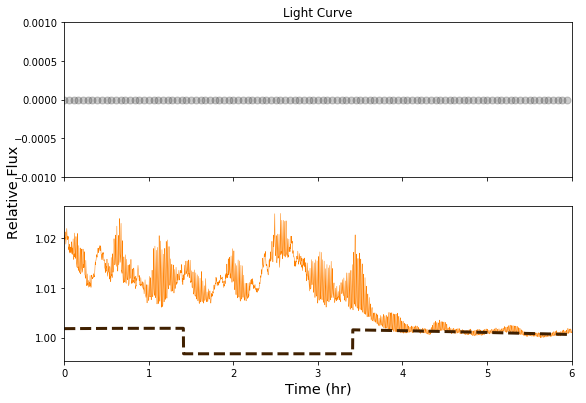

In [157]:
secs_in_hr = 3600.0

plt.figure(figsize=(9,6))

# plt.subplot2grid((6,2),(0,0),rowspan=3,colspan=1)
plt.subplot(211)
# plt.scatter(T/secs_in_hr,Y_d,c='w',alpha=0.3)
plt.scatter(T[::roller]/secs_in_hr,avg_bins_Yd,c='k',s=50,alpha=0.2)
plt.plot(T/secs_in_hr,Y,color=(0.625,0.3125,0),lw=0.5)
# plt.plot(T,A_m,'g',lw=2,alpha=0.5)
# plt.xlim([l_t,h_t]);
plt.xlim([0,6]);
# plt.xlabel('Time (hrs)',size='x-large');
plt.gca().set_xticklabels([])
Ybin_up,Ybin_dw = np.amax(avg_bins_Yd),np.amin(avg_bins_Yd)
Ybin_scl = Ybin_up - Ybin_dw
plt.ylim([Ybin_dw - 0.1*Ybin_scl,Ybin_up + 0.1*Ybin_scl])
# plt.ylabel('$F(t)$',size=30);
plt.title('Light Curve',size='large');
# plt.figtext(0.92,0.5,r'$\$_{e} = %.4f$' % significance_decl,size=30)
plt.locator_params(axis='y',nbins=6)

# plt.subplot2grid((6,2),(3,0),rowspan=3,colspan=1)
plt.subplot(212)
# plt.scatter(T/secs_in_hr,Y_d/A_m,c='k',alpha=0.25)
plt.plot(T/secs_in_hr,D_m,color=(1.0,0.5,0),lw=0.5)
plt.plot(T/secs_in_hr,A_m,color=(0.25,0.125,0),lw=3,linestyle='--')
# plt.xlim([l_t,h_t]);
plt.xlim([0,6]);
plt.xlabel('Time (hr)',size='x-large');
# Dm_up,Dm_dw = np.amax(D_m),np.amin(D_m)
# Dm_scl = Dm_up - Dm_dw
# plt.ylim([Dm_dw - 0.2*Dm_scl,Dm_up + 0.2*Dm_scl])
# plt.ylabel('$F(t)/A(t)$',size=30);
# plt.title('Detector Residuals (w/ Flux/Astro)',size=30);
# plt.figtext(0.92,0.5,r'$\Delta D = %.5f$' % ideal_Delta_D,size=30)
plt.locator_params(axis='y',nbins=6)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.gcf().add_subplot(111)
plt.gca().set_axis_bgcolor('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(labelcolor='none',top='off',bottom='off',left='off',right='off')
# plt.xlabel('Detector Amplitude / Eclipse Depth',size='x-large')
plt.ylabel('Relative Flux',size='x-large',labelpad=20)

plt.tight_layout(h_pad=2)
plt.show()

###

In [158]:
# secs_in_hr = 3600.0

# plt.figure(figsize=(9,6))

# # plt.subplot2grid((6,2),(0,1),rowspan=2,colspan=1)
# plt.subplot(311)
# # plt.hist(mini_thinner(samplerP.chain,0,int(mucorP))[:,5],50,normed=True,
# #                       color=(0,1,0),alpha=0.5)  # samplerP.chain[:,:,5].flat
# plt.hist(tfchnP[:,5],50,normed=True,color=(0,1,0),alpha=0.5)
# plt.axvline(Ecl_true[2],color=(0.25,0.125,0),linestyle='--',linewidth=3,zorder=1)
# plt.title('MCMC Posteriors',size='large')
# plt.ylabel(r'$P$-type',size='large')
# plt.gca().yaxis.set_label_position('right')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=4)
# plt.ylim([0,plt.gca().get_ylim()[1]*1.05])
# plt.xlim(plt.gca().get_xlim())
# tentoone_sub = np.load('Data_Info/10Se_1DDde_run2_PBJ_onlyEcl_ptls.npy')
# little_loopy_sing(tentoone_sub,100,2.5,True,'P')

# # plt.subplot2grid((6,2),(2,1),rowspan=2,colspan=1)
# plt.subplot(312)
# # plt.hist(mini_thinner(samplerB.chain,0,int(mucorJ))[:,5],50,normed=True,
# #                       color=(0,0,1),alpha=0.5)  # samplerB.chain[:,:,5].flat
# plt.hist(tfchnB[:,5],50,range=(0,0.02),normed=True,color=(0,0,1),alpha=0.5)  # Adding range---for main figure
# plt.axvline(Ecl_true[2],color=(0.25,0.125,0),linestyle='--',linewidth=3,zorder=1)
# plt.ylabel(r'$B$-type',size='large')
# plt.gca().yaxis.set_label_position('right')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=4)
# plt.ylim([0,plt.gca().get_ylim()[1]*1.25])
# plt.xlim(plt.gca().get_xlim())
# little_loopy_sing(tentoone_sub,100,2.5,True,'B')
# plt.xlim([0,0.02])

# # plt.subplot2grid((6,2),(4,1),rowspan=2,colspan=1)
# plt.subplot(313)
# # plt.hist(mini_thinner(samplerJ.chain,0,int(mucorJ))[:,5],50,normed=True,
# #                       color=(1,0,0),alpha=0.5)  # samplerJ.chain[:,:,5].flat
# plt.hist(tfchnJ[:,5],50,normed=True,color=(1,0,0),alpha=0.5)
# plt.axvline(Ecl_true[2],color=(0.25,0.125,0),linestyle='--',linewidth=3,zorder=1)
# plt.ylabel(r'$J$-type',size='large')
# plt.gca().yaxis.set_label_position('right')
# plt.xlabel('Eclipse Depth',size='x-large')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=4)
# plt.ylim([0,plt.gca().get_ylim()[1]*1.2])
# plt.xlim(plt.gca().get_xlim())
# little_loopy_sing(tentoone_sub,100,2.5,True,'J')

# plt.gcf().add_subplot(111)
# plt.gca().set_axis_bgcolor('none')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().tick_params(labelcolor='none',top='off',bottom='off',left='off',right='off')
# # plt.xlabel('Detector Amplitude / Eclipse Depth',size='x-large')
# plt.ylabel('Probability Density',size='x-large',labelpad=15)

# plt.tight_layout()
# plt.show()

# ###

In [159]:
# np.sum(tfchnB[:,5] > 0.02)/np.sum(tfchnB[:,5] > -0.1)

In [160]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm

In [161]:
def little_plots(low,up,n):
    plt.ylim([0,1])
    plt.yticks([])
    plt.xlim([low,up])
    plt.xticks(np.linspace(low,up,n),np.linspace(low,up,n))
    
def little_loopy(data,sz,wid,viz):  # Normally sz = 200 and wid = 5
    s1 = plt.scatter(data[1],0.75,s=sz,c=(0,1,0),zorder=2)
    p1 = plt.plot([data[0],data[2]],[0.75,0.75],lw=wid,c=(0,0.625,0),zorder=1)

    s2 = plt.scatter(data[4],0.5,s=sz,c=(0,0,1),zorder=2)
    p2 = plt.plot([data[3],data[5]],[0.5,0.5],lw=wid,c=(0,0,0.625),zorder=1)
    
    s3 = plt.scatter(data[7],0.25,s=sz,c=(1,0,0),zorder=2)
    p3 = plt.plot([data[6],data[8]],[0.25,0.25],lw=wid,c=(0.625,0,0),zorder=1)
    
    p4 = plt.axvline(0.005,color=(0.25,0.125,0),linestyle='--',linewidth=1.5,zorder=0)
    
    if viz == True:
        s1.set_label(r'$P$-type')
        s2.set_label(r'$B$-type')
        s3.set_label(r'$J$-type')

In [162]:
def extra_beta(data,btaP,btaB,btaJ,wid,alp):  # Normally wid = 5
    plt.plot([data[1] - btaP*(data[1]-data[0]),
              data[1] + btaP*(data[2]-data[1])],[0.75,0.75],lw=wid,c=(0,0.625,0),zorder=1,alpha=alp)

    plt.plot([data[4] - btaB*(data[4]-data[3]),
              data[4] + btaB*(data[5]-data[4])],[0.5,0.5],lw=wid,c=(0,0,0.625),zorder=1,alpha=alp)
    
    plt.plot([data[7] - btaJ*(data[7]-data[6]),
              data[7] + btaJ*(data[8]-data[7])],[0.25,0.25],lw=wid,c=(0.625,0,0),zorder=1,alpha=alp)

In [163]:
# # Comparing B, J, 'Actual' Knots
# # Kmu_typeJ = np.mean(samplerJ.chain[:,burn_Sj::int(mucorJ),6:6+tot_goodK],axis=(0,1))
# # Kstd_typeJ = np.std(samplerJ.chain[:,burn_Sj::int(mucorJ),6:6+tot_goodK],axis=(0,1))
# # Kmu_typeJ = np.mean(mini_thinner(samplerJ.chain,0,int(mucorJ))[:,6:6+tot_goodK],axis=0)
# # Kstd_typeJ = np.std(mini_thinner(samplerJ.chain,0,int(mucorJ))[:,6:6+tot_goodK],axis=0)

# tot_goodK = ndimJ - ndimB
# Kmu_typeB = np.mean(tf_K_repo_typeB,axis=0)
# Kstd_typeB = np.std(tf_K_repo_typeB,axis=0)
# Kmu_typeJ = np.mean(tfchnJ[:,6:6+tot_goodK],axis=0)
# Kstd_typeJ = np.std(tfchnJ[:,6:6+tot_goodK],axis=0)

# # Best set of BLISS knots
# steps_in_mychain = chnB.shape[1]  # Usually 10000, sometimes 5000
# gBnum = np.argmax(lnprobB)
# best_b_step = (gBnum % steps_in_mychain)
# best_b_walk = (gBnum - best_b_step)/steps_in_mychain
# best_K_typeB = K_repo_typeB[best_b_walk,best_b_step,:]

# i_off = 0.0
# a_lev = 0.5

# plt.figure(figsize=(12,6))
# for i in np.linspace(0,tot_goodK-1,tot_goodK):
#     plt.scatter(i-i_off,Kmu_typeB[i] - Kfl_true[i],s=50,c='b',zorder=2)
#     plt.scatter(i-i_off,best_K_typeB[i] - Kfl_true[i],marker='*',s=100,c='c',zorder=2)
#     plt.scatter(i+i_off,Kmu_typeJ[i] - Kfl_true[i],s=50,c='r',zorder=2)
#     if i == 0:
#         plt.plot(i,0,lw=3,ls='--',c='m',zorder=2)
#         plt.legend(('True',r'$B$-type',r'Best $B$-type',r'$J$-type'),loc='upper right',
#                   fontsize='small')
#     plt.plot(np.array([i-i_off,i-i_off]),np.array([Kmu_typeB[i] - Kstd_typeB[i] - Kfl_true[i],
#                                        Kmu_typeB[i] + Kstd_typeB[i] - Kfl_true[i]]),
#              lw=3,c='b',alpha=a_lev,zorder=1)
#     plt.plot(np.array([i+i_off,i+i_off]),np.array([Kmu_typeJ[i] - Kstd_typeJ[i] - Kfl_true[i],
#                                        Kmu_typeJ[i] + Kstd_typeJ[i] - Kfl_true[i]]),
#              lw=3,c='r',alpha=a_lev,zorder=1)
# plt.plot(np.array([-1,tot_goodK]),np.array([0,0]),lw=3,c='m',ls='--',zorder=1)
# plt.fill_between(np.array([-1,tot_goodK]),np.amax(Kfl_true) - np.mean(Kfl_true),
#                  np.amin(Kfl_true) - np.mean(Kfl_true),color='m',alpha=a_lev)
# plt.xlim([-1,tot_goodK]);
# plt.ylim([-0.05,0.05]);
# plt.xlabel('Knot (ID)',size='x-large');
# plt.ylabel('Discrepancy',size='x-large');
# plt.title('Knot Comparison',size='large');
# plt.show()

In [164]:
# # dum1_Dxy_Solo,dum2_Dxy_Solo = np.zeros((10,10)),np.zeros((10,10))
# dum1_Dxy_Solo,dum2_Dxy_Solo = np.zeros(Dxy_Solo.shape),np.zeros(Dxy_Solo.shape)

# bestmcmcK_B = map_flux_jumped(dum1_Dxy_Solo,(best_K_typeB - Kfl_true)/(np.amax(Kfl_true) - np.amin(Kfl_true)))
# ratioSTDknots_BJ = map_flux_jumped(dum2_Dxy_Solo,Kstd_typeB/Kstd_typeJ)

# # fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
# # F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
# # minviz = np.amin(F_avg[tmask_goodBKT])
# # maxviz = np.amax(F_avg[tmask_goodBKT])

# # plt.figure(figsize=(12,6))
# plt.figure(figsize=(6,6))

# # # plt.subplot2grid((2,6),(0,2),rowspan=2,colspan=2)
# # plt.subplot(121)
# # easy_tic = np.linspace(-1.5,1.5,7)
# # extra_bestmcmcK_B = bestmcmcK_B
# # extra_bestmcmcK_B[tmask_goodBKT == False] = np.nan
# # m_bestmcmc = plt.imshow(extra_bestmcmcK_B,interpolation='hermite',origin='lower',
# #                       extent=[x_Knots[0],x_Knots[-1],y_Knots[0],y_Knots[-1]],
# #                       cmap=cm.coolwarm,vmin=-1.5,vmax=1.5)
# # m_bestmcmc.cmap.set_bad(color='w',alpha=0.0)
# # plt.colorbar(m_bestmcmc,extend='both',label=r'(BLISS - True) / $\Delta$ True',ticks=easy_tic,shrink=0.75)
# # plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# # # plt.xticks([])
# # plt.xlabel('Pixel x',size='x-large');
# # plt.ylabel('Pixel y',size='x-large');
# # # plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# # plt.title(r'Best $B$-type vs True Map',size='large')
# # plt.locator_params(axis='x',nbins=6)
# # plt.locator_params(axis='y',nbins=6)

# # # plt.subplot2grid((2,6),(0,4),rowspan=2,colspan=2)
# # plt.subplot(122)
# extra_ratioSTDknots_BJ = ratioSTDknots_BJ
# extra_ratioSTDknots_BJ[tmask_goodBKT == False] = np.nan  # So bad knots fall outside the color range.

# m_ratioBJ = plt.imshow(extra_ratioSTDknots_BJ,interpolation='hermite',origin='lower',
#            extent=ext_bounds,cmap=cm.plasma,vmin=0.2,vmax=0.81)  # cmap=cm.inferno
# # m_ratioBJ.cmap.set_bad(color='w',alpha=1.0)
# plt.colorbar(m_ratioBJ,extend='neither',
#              label='Ratio of Standard Deviations',ticks=np.linspace(0.2,0.8,7),shrink=0.75)  # label='STD[ $B$-type ] / STD[ $J$-type ]'
# plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# plt.xlabel('Pixel x',size='x-large');
# plt.ylabel('Pixel y',size='x-large');
# # plt.scatter(xKmesh,yKmesh,color=(1,1,1),marker='x',alpha=0)
# plt.title(r'$B$-type / $J$-type Knots',size='large')
# plt.locator_params(axis='x',nbins=6)
# plt.locator_params(axis='y',nbins=6)

# # plt.tight_layout(w_pad=3)
# plt.tight_layout()
# plt.show()

# ###

In [165]:
#####
# Misc. Area
#####

In [166]:

# # # RELOAD AREA (Everything)- NOT REALLY, IN THIS NOTEBOOK # # #


In [167]:
def bic_upping(pchi,pbic,bchi,bbic,bbicL,jchi,jbic,pparam,bparam,jparam,n_data):
    pnew = pbic + 9.0*pchi + 2.303*pparam
    
    if int(n_data) == 1080:
        bjterm = 85.86
    elif int(n_data) == 2160:
        bjterm = 92.10
    elif int(n_data) == 4320:
        bjterm = 98.34
        
    bnew = bbic + 9.0*bchi + 16.12 + (jparam - 7)*bjterm
    bnewL = bbicL + 9.0*bchi + 16.12
    
    jnew = jbic + 9.0*jchi + 16.12 + (jparam - 7)*bjterm
    
    return pnew,bnew,bnewL,jnew

In [168]:
def bayes_evid_estim(pchain,bchain,knotchain,jchain,cols,typ,norm):
#     lim = min(pchain.shape[0],bchain.shape[0],jchain.shape[0])  # use shortest chain to limit data
    
#     pcov = np.cov(pchain[:lim,cols],rowvar=0)
#     bcov = np.cov(bchain[:lim,cols],rowvar=0)
#     jcov = np.cov(jchain[:lim,cols],rowvar=0)

#     bchainfull = np.concatenate((bchain[:,:-1],knotchain,
#                                  np.transpose(np.array([bchain[:,-1]]))),axis=1)
    
    pcov = np.cov(pchain[:,cols],rowvar=0) # rowvar of 0 means columns are variables; 1 is vice versa
    bcov = np.cov(bchain[:,cols],rowvar=0)
    jcov = np.cov(jchain[:,cols],rowvar=0)
#     bcovf = np.cov(bchainfull,rowvar=0)
#     jcovf = np.cov(jchain,rowvar=0)
    
    if typ == 'Vals':
        phyp = (np.linalg.det(pcov))**0.5  # Sqrt of det. of cov.
        bhyp = (np.linalg.det(bcov))**0.5
        jhyp = (np.linalg.det(jcov))**0.5
#         bhypf = (np.linalg.det(bcovf))**0.5
#         jhypf = (np.linalg.det(jcovf))**0.5
        
        if norm == 'Yes':
            scale = min(phyp,bhyp,jhyp)  # Report relative to minimum
            phyp = phyp/scale
            bhyp = bhyp/scale
            jhyp = jhyp/scale
#             scalef = min(bhypf,jhypf)
#             bhypf = bhypf/scalef
#             jhypf = jhypf/scalef
            
    elif typ == 'Logs':
        base_chg = np.log(10.0)
        
        psgn,phyp = np.linalg.slogdet(pcov)  # ln of det. of cov.
        bsgn,bhyp = np.linalg.slogdet(bcov)
        jsgn,jhyp = np.linalg.slogdet(jcov)
#         bsgnf,bhypf = np.linalg.slogdet(bcovf)
#         jsgnf,jhypf = np.linalg.slogdet(jcovf)
        
        phyp = 0.5*(phyp/base_chg)  # base 10 log of sqrt of det. of cov. 
        bhyp = 0.5*(bhyp/base_chg)
        jhyp = 0.5*(jhyp/base_chg)
#         bhypf = 0.5*(bhypf/base_chg)
#         jhypf = 0.5*(jhypf/base_chg)
        
        if norm == 'Yes':
            scale = min(phyp,bhyp,jhyp)  # Report relative to minimum
            phyp = phyp - scale
            bhyp = bhyp - scale
            jhyp = jhyp - scale
#             scalef = min(bhypf,jhypf)
#             bhypf = bhypf - scalef
#             jhypf = jhypf - scalef
    
    return phyp,bhyp,jhyp  #,bhypf,jhypf

In [169]:
ndimP,ndimB,ndimJ

(12, 7, 74)

In [170]:
# print('chisq')
# if yesdoJ == True:
#     print(np.around((gP_chisq,gB_chisq,gJ_chisq),1))
# else:
#     print(np.around((gP_chisq,gB_chisq),1))

In [171]:
# print('bic')
# if yesdoJ == True:
#     print(np.around((gP_bic,gB_bic,gJ_bic),1)),print(np.around(gB_bicLow,1))
# else:
#     print(np.around((gP_bic,gB_bic),1)),print(np.around(gB_bicLow,1))

In [172]:
# # # # # Beta Factors

from numpy.lib import stride_tricks
from matplotlib.ticker import ScalarFormatter

In [173]:
def best_model_maker(natlogprob,mcmc_chain,mcmc_steps):
    best_num = np.argmax(natlogprob)
    best_step = (best_num % mcmc_steps)
    best_walker = (best_num - best_step)/mcmc_steps
    theta = mcmc_chain[best_walker,best_step]
    return theta

In [174]:
# FYI!: Hijacking and just using F(t)/A(t) to "guess" how the best-fit (B-type ONLY!!) residuals would look.

def best_resids_maker(natlogprob,mcmc_chain,mcmc_steps,t_sing,y_d,n_data,run_type):
#     theta = best_model_maker(natlogprob,mcmc_chain,mcmc_steps) # theta can have: 3A, 3E, #C, #K, 3Cov, 1SF
    
#     astro = theta[:3]
#     ecl = theta[3:6]
#     y_ast = perf_astro_model(t_sing[0],t_sing[-1],t_sing,astro,ecl)
    astro = Ast_true
    ecl = Ecl_true
    y_ast = A_m  # New key lines
#     if Cov_key == True:
#         sx,sy,rho = theta[-3+SF_i],theta[-2+SF_i],theta[-1+SF_i]
    
    if run_type == 'P':
        cn_out_Vector[:polyO_out] = theta[6:6+polyO_out]
        cn_out_Vector[polyO_out+1:] = theta[6+polyO_out:6+Cn_out]
        C_UTout[UTout_i] = cn_out_Vector
        if Cov_key == True:
            if FastRYX_key == True:
                d_model = sigxy_DM_alt(C_UTout,xKmesh,yKmesh,sx,sy,rho,DProb_LookTab,n_data)
            else:
                d_model = sigxy_detect_model(C_UTout,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,n_data)
        else:
            d_model = perf_detect_model(xNt_vals,yNt_vals,C_UTout,n_data)
    else:
        if run_type == 'B':
            if Cov_key == True:
                if FastRYX_key == True:
                    sens_map = map_FE_alt(y_d,y_ast,sx,sy,rho,DProb_LookTab)
                else:
                    sens_map = map_flux_eval(y_d,y_ast,mask_EtoK,xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho)
            else:
                sens_map = map_flux_avgQuick(y_d,y_ast,xNt_B_lin)
            d_model = bliss_meth(n_data,flux_bliss,sens_map,xNt_vals,yNt_vals)
        elif run_type == 'J':
            f_knots = theta[6:6+tot_goodK]
            if Cov_key == True:
                if FastRYX_key == True:
                    d_model = sigxy_EVM_alt(Dxy_Solo,f_knots,sx,sy,rho,DProb_LookTab,n_data)
                else:
                    d_model = sigxy_eval_map(Dxy_Solo,f_knots,f_bliss_Egrid,f_bliss_Evect,xoE,yoE,
                                             xEmesh_n,yEmesh_n,xNt_vals,yNt_vals,sx,sy,rho,n_data)
            else:
                sens_map = map_flux_jumped(Dxy_Solo,f_knots)
                d_model = bliss_meth(n_data,flux_bliss,sens_map,xNt_vals,yNt_vals)
    
    resids = y_d - (y_ast*d_model)

#     if SigF_key == True:
#         sF = theta[-1:]
#         lglike = -n_data*np.log(sF) - 0.5*np.sum((numer/sF)**2.0)  # Corrected: include "n_data"
#     else:
#         lglike = -n_data*np.log(SigF_true) - 0.5*np.sum((numer/SigF_true)**2.0)
        
    return y_ast*d_model,resids

In [175]:
def rolling(vec,window):
    new_dim = ((vec.size - window + 1),window)
    new_bytes = (vec.itemsize,vec.itemsize)
    return stride_tricks.as_strided(vec,shape=new_dim,strides=new_bytes)

In [176]:
# Finding which bin sizes will have even numbers of data points

all_divisors = np.where((N*np.ones(N) % np.linspace(1,N,N)) == 0)[0] + 1

In [177]:
# def poisson_scatter(sigf,n_data):
#     ideal_scat = sigf/(np.linspace(1,n_data,n_data)**0.5)  # Poisson limit for each bin size
#     return ideal_scat

def poisson_scatter(sigf,divs):
    ideal_scat = sigf/(divs**0.5)  # Poisson limit for each bin size
    return ideal_scat

In [178]:
# def beta_plotter(resids,n_data):
#     binned_scat = np.zeros(n_data)
#     for n in np.linspace(1,n_data,n_data):
#         if n == 1:
#             binned_scat[n-1] = np.mean(resids**2.0)**0.5
#         else:
#             chunks = rolling(resids,n)
#             binned_scat[n-1] = np.mean(np.mean(chunks,axis=1)**2.0)**0.5
#     return binned_scat

def beta_plotter(resids,divs):
    binned_scat = np.zeros(divs.shape)
    for i in np.linspace(1,len(divs),len(divs)):
        if i == 1:
            binned_scat[i-1] = np.mean(resids**2.0)**0.5
        else:
            chunks = rolling(resids,divs[i-1])[::divs[i-1]]  # Only taking unique bins
            binned_scat[i-1] = np.mean(np.mean(chunks,axis=1)**2.0)**0.5
    return binned_scat

In [179]:
def beta_visual(mybins,myideal,myuncert,tit,mycolor,n_data):
    plt.plot(mybins,myuncert,c=mycolor)
    plt.plot(mybins,myideal,'k',ls='--')
    plt.gca().set_xscale('log')
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.gca().set_yscale('log')
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.xlim([1,n_data])
    plt.xlabel('Bin Size',size='large')
    plt.ylim([np.amin(myuncert)*0.75,np.amax(myuncert)*1.3])
    plt.ylabel('RMS Scatter',size='large')
    this_beta = np.amax(myuncert/myideal)
    plt.title(tit+r' $\beta$ = %.3f' % this_beta,size='large')
    if this_beta >= 1.0:
        return this_beta
    else:
        return 1.0

In [180]:
# chain_sizes,chain_sizesB = chnP.shape[1],chnB.shape[1]

# bestfit_model_P,bestfit_resids_P = best_resids_maker(lnprobP,chnP,chain_sizes,T,Y_d,N,'P')
# bestfit_model_B,bestfit_resids_B = best_resids_maker(lnprobB,chnB,chain_sizesB,T,Y_d,N,'B')
# bestfit_model_J,bestfit_resids_J = best_resids_maker(lnprobJ,chnJ,chain_sizes,T,Y_d,N,'J')

# poiss_uncert = poisson_scatter(SigF_true,N)

poiss_uncert = poisson_scatter(SigF_true,all_divisors)

# bins_uncert_P = beta_plotter(bestfit_resids_P,N)
# bins_uncert_B = beta_plotter(bestfit_resids_B,N)
# bins_uncert_J = beta_plotter(bestfit_resids_J,N)

# bins_uncert_P = beta_plotter(bestfit_resids_P,all_divisors)
# bins_uncert_B = beta_plotter(bestfit_resids_B,all_divisors)
# bins_uncert_J = beta_plotter(bestfit_resids_J,all_divisors)

In [181]:
# # plt.figure(figsize=(12,4))
# plt.figure(figsize=(6,6))

# # all_bin_nums = np.linspace(1,N,N)

# # plt.subplot(131)
# # # beta_visual(all_bin_nums,poiss_uncert,bins_uncert_P,r'$P$-type','g',N)
# # ppp_Beta = beta_visual(all_divisors,poiss_uncert,bins_uncert_P,r'$P$-type','g',N)

# # plt.subplot(132)
# # beta_visual(all_bin_nums,poiss_uncert,bins_uncert_B,r'$B$-type','b',N)
# bbb_Beta = beta_visual(all_divisors,poiss_uncert,bins_uncert_B,r'$B$-type','b',N)

# # plt.subplot(133)
# # # beta_visual(all_bin_nums,poiss_uncert,bins_uncert_J,r'$J$-type','r',N)
# # jjj_Beta = beta_visual(all_divisors,poiss_uncert,bins_uncert_J,r'$J$-type','r',N)
# # if yesdoJ == False:
# #     jjj_Beta = 1.0

# plt.tight_layout()
# plt.show()

In [182]:
# # To save beta values (for getting z-scores later.)
# # np.save(file_Name+'PBJ_Betas',np.array([ppp_Beta,bbb_Beta,jjj_Beta]))

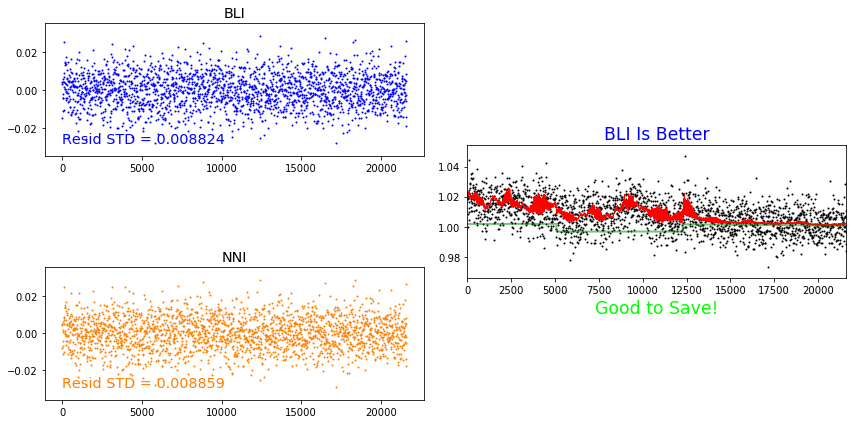

Knots dx
0.0154100385733
Knots dy
0.0172245738554
s_BLI / s_NNI
0.996142188881


In [183]:
# # Should automatically do both BLI and NNI tests because you're using A(t) for both, i.e. no chains needed.

plt.figure(figsize=(12,6))

# BLI
all_NNI_key = False
NNI,BLS = which_NNI(tBK_T,low_bx,high_bx,low_by,high_by)  # Data masks (rerun for BLI here, to be safe)
# bestfit_model_Bbli,bestfit_resids_Bbli = best_resids_maker(lnprobB,chnB,chain_sizesB,T,Y_d,N,'B')
bestfit_model_Bbli,bestfit_resids_Bbli = best_resids_maker('lnprobB','chnB','chain_sizesB',T,Y_d,N,'B')

plt.subplot2grid((7,2),(0,0),rowspan=3,colspan=1)
plt.scatter(T,bestfit_resids_Bbli,s=1,c=(0,0,1))
plt.title('BLI',size='x-large')
plt.text(0,np.amin(bestfit_resids_Bbli),'Resid STD = %.6f' % (np.std(bestfit_resids_Bbli)),
         size='x-large',color=(0,0,1))

# NNI
plt.subplot2grid((7,2),(4,0),rowspan=3,colspan=1)
all_NNI_key = True
NNI,BLS = which_NNI(tBK_T,low_bx,high_bx,low_by,high_by)  # Data masks (rerun for NNI here)
# bestfit_model_Bnni,bestfit_resids_Bnni = best_resids_maker(lnprobB,chnB,chain_sizesB,T,Y_d,N,'B')
bestfit_model_Bnni,bestfit_resids_Bnni = best_resids_maker('lnprobB','chnB','chain_sizesB',T,Y_d,N,'B')

plt.scatter(T,bestfit_resids_Bnni,s=1,c=(1,0.5,0))
plt.title('NNI',size='x-large')
plt.text(0,np.amin(bestfit_resids_Bnni),'Resid STD = %.6f' % (np.std(bestfit_resids_Bnni)),
         size='x-large',color=(1,0.5,0))

plt.subplot2grid((7,2),(2,1),rowspan=3,colspan=1)
plt.scatter(T,Y_d,c='k',s=1)
plt.plot(T,Y,'r',lw=1)
plt.plot(T,A_m,'g',lw=2,alpha=0.5)
plt.xlim([l_t,h_t]);
Yd_up,Yd_dw = np.amax(Y_d),np.amin(Y_d)
Yd_scl = Yd_up - Yd_dw
plt.ylim([Yd_dw - 0.1*Yd_scl,Yd_up + 0.1*Yd_scl])
# plt.title('Data and Models',size='x-large');
if np.std(bestfit_resids_Bbli) < np.std(bestfit_resids_Bnni):
    plt.title('BLI Is Better',size='xx-large',color=(0,0,1))
    if (np.std(bestfit_resids_Bbli)/np.std(bestfit_resids_Bnni)) > 0.99:
        plt.xlabel('Good to Save!',size='xx-large',color=(0,1,0))
    else:
        plt.xlabel(r's_BLI/s_NNI < 0.99 $\Rightarrow$ Sketchy Fit?',size='xx-large',color=(0.75,0.75,0))
else:
    plt.title('NNI Is Better',size='xx-large',color=(1,0.5,0))
    plt.xlabel('No Dice!!!',size='xx-large',color=(1,0,0))
        

plt.tight_layout()
# plt.savefig('/Users/Joel/Desktop/BLISS MCMC/BLIvNNI/'+'100Se_5DDe_onlyLinOrd_'+'.pdf')

plt.show()

print("Knots dx")
print(delta_xo)
print("Knots dy")
print(delta_yo)
print("s_BLI / s_NNI")
print(np.std(bestfit_resids_Bbli)/np.std(bestfit_resids_Bnni))

In [184]:
# ## SAVING AREA

# file_Name = 'Data_Info/10Se_10DDde_run???_'  # Description of dataset

# np.save(file_Name+'EMCEE_PBJ_priors',np.concatenate((P_rP,P_rB,P_rJ),axis=1))

# np.save(file_Name+'EMCEE_PBJ_true',np.concatenate((Ast_true,Ecl_true,DCs_true,DCs_fit_true,
#                                                    Kfl_true,Cov_true,SigF_true)))
# np.save(file_Name+'EMCEE_PBJ_data',np.vstack((T,A_m,D_m,Y,Y_d,xNt_vals,yNt_vals,xNt_perf,yNt_perf)))
# np.save(file_Name+'EMCEE_PBJ_polyOCn',np.array([polyO_in,Cn_in,polyO_out,Cn_out]))

# if Brown_key == True:
#     np.save(file_Name+'EMCEE_PBJ_brownsignal',Bro_noi)
    
# if want_noisyM_key == True:
#     np.save(file_Name+'EMCEE_PBJ_splinyMnoise',Master_pixNoi)

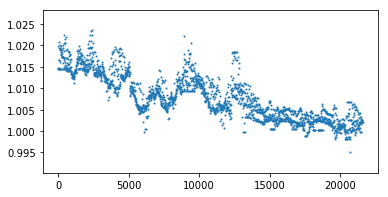

In [185]:
plt.figure(figsize=(6,3))
plt.scatter(T,bestfit_model_Bbli,s=1)
plt.show()

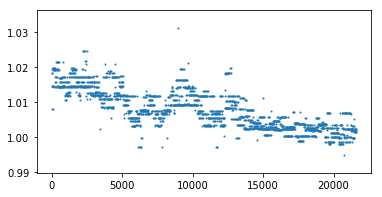

In [186]:
plt.figure(figsize=(6,3))
plt.scatter(T,bestfit_model_Bnni,s=1)
plt.show()

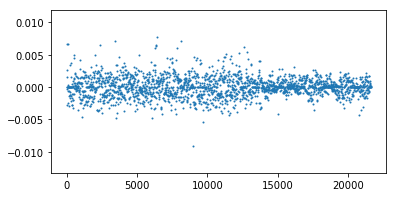

In [187]:
plt.figure(figsize=(6,3))
plt.scatter(T,bestfit_model_Bbli - bestfit_model_Bnni,s=1)
plt.show()

In [188]:
# holdplease = bestfit_model_Bbli
# holdpleasenni = bestfit_model_Bnni

In [189]:
# plt.figure(figsize=(18,9))
# plt.plot(T[200:],holdplease[200:],'k')
# plt.plot(T[200:],bestfit_model_Bbli[200:] - 0.1,'r')
# plt.show()

In [190]:
# # Faster 'B'-type flux summation using 'np.bincount' (learned while dealing with slow covariance functions) 
# def map_flux_avgQuick(data,ast,dxyi_lin):
#     dxy_map = ((np.bincount(dxyi_lin,weights=data/ast,
#                             minlength=(N_bin*N_bin)).reshape((N_bin,N_bin)))/tBK_T)  # Avg flux at each data knot
#     return dxy_map  # Using [y,x] for consistency

# # Note use of 'minlength': you'd often get output that's too short otherwise! (i.e. not EVERY possible knot)

In [191]:
# def bliss_meth(n_data,b_flux,dxy_map,x_o,y_o):
# #     b_flux[:] = 0  # Probably unnecessary?
#     LL = dxy_map[low_by,low_bx]*LL_dst  # Using [y,x] for consistency
#     LR = dxy_map[high_by,low_bx]*LR_dst
#     UL = dxy_map[low_by,high_bx]*UL_dst
#     UR = dxy_map[high_by,high_bx]*UR_dst
#     b_flux[BLS] = (LL[BLS] + LR[BLS] + UL[BLS] + UR[BLS])/(delta_xo*delta_yo)  # BLISS points
#     b_flux[NNI] = dxy_map[yNt_B_i[NNI],xNt_B_i[NNI]]  # Nearest Neighbor points
# #     b_flux = n_data*b_flux/np.sum(b_flux)  # Normalizing as above
#     return b_flux

In [192]:
# sens_map = map_flux_avgQuick(y_d,y_ast,xNt_B_lin)
# d_model = bliss_meth(n_data,flux_bliss,sens_map,xNt_vals,yNt_vals)

In [193]:
# plt.plot(UL_dst)
# plt.plot(LL_dst)

In [194]:
# lkup = 100
# plt.scatter(xNt_vals[lkup],yNt_vals[lkup],s=30,c='k')
# plt.scatter(low_Kx[lkup],low_Ky[lkup],s=30,c='g')
# plt.scatter(high_Kx[lkup],low_Ky[lkup],s=30,c='r')
# plt.scatter(low_Kx[lkup],high_Ky[lkup],s=30,c='y')
# plt.scatter(high_Kx[lkup],high_Ky[lkup],s=30,c='b')

# plt.xlim(x_Knots[0],x_Knots[-1])
# plt.ylim(y_Knots[0],y_Knots[-1])
# plt.show()

# print('Green dist = %.5f' % LL_dst[lkup])
# print('Red dist = %.5f' % LR_dst[lkup])
# print('Yellow dist = %.5f' % UL_dst[lkup])
# print('Blue dist = %.5f' % UR_dst[lkup])

In [195]:
# np.absolute((xNt_vals[lkup] - low_Kx[lkup])*(yNt_vals[lkup] - high_Ky[lkup]))